# <ins>**Notebook 5**</ins>: **Modelización** ***Survival Machine Learning***

### <ins>**Propósito**</ins>

Este notebook tiene como objetivo <ins>**desarrollar los modelos**</ins> <ins>***Survival Machine Learning***</ins> **establecidos como objetivo:** <ins>***Random Survival Forest (RSF)***</ins> y <ins>***Cox Proportional Hazards***</ins>. Se efectúan **modelizaciones tanto a nivel** <ins>**General**</ins> (considerando la totalidad de la base) como por <ins>***Rubro***</ins>.

---

### <ins>**Objetivos**</ins>

- **<ins>Modelizar la base</ins> `df_Price_spells_SML.feather` <ins>utilizando algoritmos de Survival Analysis</ins>, tanto de forma general como discriminando por *Rubro*.**

- <ins>**Establecer**</ins>, tanto para el modelo general como para los específicos por *Rubro*, <ins>**cuál de los modelos presenta mejor desempeño:**</ins> <ins>***Random Survival Forest* (RSF)**</ins> o <ins>***Cox Proportional Hazards***</ins>. **Para ello, se calcula el** <ins>**C-Index**</ins>, **con el objetivo de determinar cuál de los modelos alcanza un** **<ins>mayor valor</ins>** **en dicho indicador**.

- <ins>**Determinar, para todos los modelos, el valor de la métrica MAE Uncensored</ins>, utilizando con dicho fin la librería *SurvivalEVAL***. **El** <ins>**propósito**</ins> detrás de este cálculo es <ins>**comparar los resultados obtenidos para la modelización general y la específica por Rubro con los obtenidos para dicha métrica en**</ins> `Notebook 4: Modelización tradicional de Machine Learning`

---

### <ins>**Archivos necesarios**</ins>

1. **<ins>df_Price_spells_SML.feather</ins>** → Base que contiene las series temporales de *Price Spells* de los pares establecimiento-producto en Montevideo, correspondientes al período *Enero 2021 - Junio 2024*.

---

### <ins>**Archivos generados**</ins>

**(graficas y archivos generados en el entorno)**

1. **<ins>Archivos `.pkl` con los modelos entrenados (General y por *Rubro*)</ins>**  
   **Para cada *Rubro* analizado** (*Alimentos, Bebidas con Alcohol, Bebidas sin Alcohol, Cuidado Personal y Limpieza*) **y para el modelo general, se generan dos archivos `.pkl` que almacenan los modelos entrenados:**  
   - `Random_Survival_Forest_<rubro o general>.pkl`  
   - `Cox_Proportional_Hazards_Model_<rubro o general>.pkl`  


2. **<ins>Gráficos de curva de supervivencia (General y por *Rubro*)</ins>**  
   Generación de gráficos `.png` que contienen las **curvas de supervivencia estimadas en cada modelización realizada**:  
   - `Random_Survival_Forest_Curva_de_Supervivencia_<rubro o general>.png`  
   - `Cox_Proportional_Hazards_Model_Curva_de_Supervivencia_<rubro o general>.png`  


3. **<ins>Resumen_Resultados.xlsx (General y por *Rubro*)</ins>**  
   **Archivo que contiene un resumen consolidado de las métricas obtenidas por modelo y rubro**; incluyendo *C-Index*, *MAE Uncensored* y *Características*.  


4. **<ins>Comparative Results (Train vs Test).xlsx (General y por *Rubro*)</ins>**  
   **Comparación del desempeño entre conjuntos de entrenamiento** *(Train)* **y prueba** *(Test)*.

# **0. Librerías**

In [2]:
## INSTALACIÓN DE BIBLIOTECAS ##

!python -m pip install --upgrade pip # Última versión de Python
!pip install pyarrow # Instalación libreria pyarrow
!pip install seaborn -q # Instalación de la librería seaborn
!pip install scikit-survival # Instalación libreria scikit-survival
!pip install xgboost --no-cache-dir # Instalación de la librería xgboost
!pip install lightgbm # Instalación de la librería lightgbm
!pip install openpyxl # Instalación de la librería openpyxl
!pip install seaborn -q # Instalación de la librería seaborn
!pip install optuna -q # Instalación de la librería optuna
!pip install lifelines # Instalación de la librería lifetimes
!pip install matplotlib -q # Instalar matplotlib
#!pip install git+https://github.com/shi-ang/SurvivalEVAL.git # Instalación de la librería de github SurvivalEVAL

In [3]:
## CARGA DE LIBRERÍAS ##

# Manipulación de datos
import pandas as pd  # pandas
import numpy as np   # Numpy
import os #Os
import joblib #Joblib
from datetime import datetime #Datetime
from openpyxl import load_workbook #Guardado de resultados en Excel

# Visualización
import matplotlib.pyplot as plt  # Matplotlib
import seaborn as sns  # seaborn
from matplotlib.colors import LinearSegmentedColormap # Paleta de colores
from matplotlib import rcParams # rcParams

# Lifetime
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi
#from SurvivalEVAL.Evaluator import LifelinesEvaluator

# Survival
from sksurv.util import Surv # Survival
from sklearn.compose import ColumnTransformer # ColumnTransformer
from sksurv.ensemble import RandomSurvivalForest # RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis # BoostingSurvivalAnalysis
from sksurv.linear_model import CoxnetSurvivalAnalysis # CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored # C-Index
from sklearn.model_selection import GridSearchCV # GridSearchCV
from sklearn.metrics import make_scorer # Makescorer
from sklearn.model_selection import train_test_split #S pliteo de train y test
from sklearn.preprocessing import OneHotEncoder # OneHotEncoder
from sklearn.preprocessing import StandardScaler # StandardScaler
from sklearn.preprocessing import MinMaxScaler # MinMaxScaler
from openpyxl.styles import PatternFill # PatternFill
import optuna # Optuna
import xgboost as xgb #XGB
from xgboost import XGBRegressor #XGBoostRegressor

In [4]:
## OTROS ##

# Desactivamos todos los warnings
import warnings
warnings.filterwarnings("ignore")

# Seting de Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Configuramos directamente DejaVu Sans para títulos de gráficos
rcParams['font.family'] = 'DejaVu Sans' 

In [5]:
## PALETA DE COLORES ##

# Colores por defecto
main_colours = {
    'Blues_Tone_1': '#012f75',
    'Blues_Tone_2': '#023e8a',
    'Blues_Main_Tone': '#0454a4',
    'Blues_Tone_4': '#3b7fd1',
    'Blues_Tone_5': '#6cae6',
    'Golden_Tone_1': '#7d5d1f',
    'Golden_Tone_2': '#936f2b',
    'Golden_Main_Tone': '#d1a956',
    'Golden_Tone_4': '#e2c178',
    'Golden_Tone_5': '#f8e8d1',
    'Oranges_Tone_1': '#8c3e19',
    'Oranges_Tone_2': '#b35422',
    'Oranges_Main_Tone': '#e66b23',
    'Oranges_Tone_4': '#e9956b',
    'Oranges_Tone_5': '#f9c4a5',
    'Greys_Tone_1': '#84828e',
    'Greys_Tone_2': '#9c9aa7',
    'Greys_Main_Tone': '#bdbbc9',
    'Greys_Tone_4': '#d3d2da',
    'Greys_Tone_5': '#e9e8f0',
    'Whites_Tone_1': '#f2f2f2',
    'Whites_Tone_2': '#e5e5e5',
    'Whites_Main_Tone': '#f7f7f7',
    'Whites_Tone_4': '#fafafa',
    'Whites_Tone_5': '#fdfdfd',
}

# Paletas predefinidas en Matplotlib
paletas_predefinidas = ['Blues', 'Greys', 'Oranges']

# Paletas personalizadas
Goldens = ["#f8e8d1", "#e2c178", "#d1a956", "#b69038", "#7d5d1f"]
Sky_Blues = ["#e0f7fa", "#90e0ef", "#48cae4", "#00b4d8", "#0077b6"]

# Crear mapas de colores con gradientes ajustados
cmap_dorados_muy_suave = LinearSegmentedColormap.from_list("goldens", Goldens)
cmap_celestes_muy_suave = LinearSegmentedColormap.from_list("aky_blues", Sky_Blues)

# Paleta de colores para representar RUBROS
color_dict = {
    'Alimentos': plt.get_cmap('Blues')(0.8),
    'Bebidas con Alcohol': plt.get_cmap('Oranges')(0.5),
    'Bebidas sin Alcohol': cmap_dorados_muy_suave(0.5),
    'Cuidado Personal': cmap_celestes_muy_suave(0.5),
    'Limpieza': plt.get_cmap('Greys')(0.5)
}

# Función para visualizar las paletas de colores
def mostrar_paletas_combinadas(paletas, cmap_gradientes, nombres_gradientes):
    plt.figure(figsize=(8, 10))

    # Mostrar paletas predefinidas
    for i, paleta in enumerate(paletas):
        plt.subplot(len(paletas) + len(cmap_gradientes), 1, i + 1)
        plt.imshow([np.linspace(0, 1, 256)], aspect='auto', cmap=plt.get_cmap(paleta))
        plt.title(paleta, loc='left', fontsize=10)
        plt.axis('off')

    # Mostrar gradientes personalizados (dorados y celestes)
    for i, (cmap, nombre) in enumerate(zip(cmap_gradientes, nombres_gradientes)):
        plt.subplot(len(paletas) + len(cmap_gradientes), 1, len(paletas) + i + 1)
        plt.imshow([np.linspace(0, 1, 256)], aspect='auto', cmap=cmap)
        plt.title(nombre, loc='left', fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# **1. <ins>Carga de Base de datos</ins>** ***Survival Machine Learning*** *(Enero 2021 - Junio 2024)*

### **1.1**  **Carga de bases <ins>Precios</ins>**

In [6]:
## CARGA BASE DE DATOS SURVIVAL MACHINE LEARNING ##

# Cargamos de base Complete Depurado
df_price_spells = pd.read_feather('df_Price_spells_SML.feather')

In [7]:
# Convertimos las columnas Año, Mes y Día_del_mes a tipo object
df_price_spells['Año'] = df_price_spells['Año'].astype(str)
df_price_spells['Mes'] = df_price_spells['Mes'].astype(str)

In [8]:
## CONTABILIZACIÓN DE SPELLS ##

# Contamos la cantidad de casos por "Tipo de Serie"
serie_counts = df_price_spells["Tipo de Serie"].value_counts()

# Calculamos el porcentaje de cada categoría
total_count = serie_counts.sum()
serie_percentages = (serie_counts / total_count) * 100

# Formateamos el resultado con el porcentaje entre paréntesis
serie_summary = serie_counts.astype(str) + " (" + serie_percentages.round(2).astype(str) + "%)"

# Mostramos el resultado
serie_summary

Tipo de Serie
Complete             352274 (62.52%)
Left Sensored        102043 (18.11%)
Right Sensored        59341 (10.53%)
Centre Sensored        27298 (4.84%)
Interval Sensored       22514 (4.0%)
Name: count, dtype: object

In [9]:
### DEFINICIÓN VARIABLE EVENTO ###

# En análisis de supervivencia, el "evento" es el suceso que queremos modelar, en este caso, 
# el final del spell (cuando el precio cambia y se confirma su duración total).

# La columna "Censurado" en tu base indica:
# - Censurado = 0 -> El spell NO está truncado, es decir, se observó completamente su duración 
# - Censurado = 1 -> El spell SÍ está truncado, es decir, no sabemos cuánto habría durado realmente 

# Se define la variable "Evento":
# - evento = 1 - Censurado
df_price_spells["Evento"] = 1 - df_price_spells["Censurado"]
df_price_spells["Evento"] = df_price_spells["Evento"].astype(int).values.ravel()

In [10]:
### DEFINICIÓN VARIABLE TIEMPO ###

# "Duración" representa el tiempo que duró cada spell, ya sea censurado o no.
time_variable = "Duración"

In [11]:
### DEFINICIÓN VARIABLES PREDICTORAS ###

# Definimos las columnas categóricas y numéricas a incluir
categorical_columns = ['Cadena', 'Tipo_establecimiento', 'Categoria', 'Mes', 'Municipio', 'Día_del_mes', 'Día_de_la_semana']
numeric_columns = ['Promoción', 'Lag_Duración1', 'Var_Precio_%']

# Filtramos el DataFrame para conservar solo las columnas deseadas
X = df_price_spells[categorical_columns + numeric_columns]

In [12]:
df_price_spells.head(5)

,ID_establecimiento,Nombre_sucursal,Cadena,Tipo_establecimiento,Barrio,Municipio,ID_producto,Nombre,Rubro,Categoria,...,Promoción,Censurado,Año,Trimestre,Mes,Día_del_mes,Día_de_la_semana,Feriado,Tipo de Serie,Evento
0,2,Expres 6,Sin Cadena,Minimercado,La Teja,Municipio A,1,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,...,0,1,2021,Q1,1,1,Friday,1,Complete,0
1,2,Expres 6,Sin Cadena,Minimercado,La Teja,Municipio A,1,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,...,0,0,2021,Q1,1,13,Wednesday,0,Complete,1
2,2,Expres 6,Sin Cadena,Minimercado,La Teja,Municipio A,1,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,...,0,0,2021,Q1,1,14,Thursday,0,Complete,1
3,2,Expres 6,Sin Cadena,Minimercado,La Teja,Municipio A,1,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,...,0,0,2021,Q1,1,26,Tuesday,0,Complete,1
4,2,Expres 6,Sin Cadena,Minimercado,La Teja,Municipio A,1,Aceite de girasol Óptimo Envase 900 cc,Alimentos,Aceites,...,0,0,2021,Q1,2,3,Wednesday,0,Complete,1


In [13]:
## CANTIDAD DE REGISTROS EN BASE ##

# Contamos la cantidad de productos y establecimientos únicos
num_productos_unicos = df_price_spells["ID_producto"].nunique()
num_establecimientos_unicos = df_price_spells["ID_establecimiento"].nunique()

# Contamos las combinaciones únicas de establecimiento-producto
num_combinaciones_unicas = df_price_spells[["ID_establecimiento", "ID_producto"]].drop_duplicates().shape[0]

# Agrupamos por "Rubro" para contar productos únicos y establecimientos únicos
resumen_rubro = df_price_spells.groupby("Rubro").agg({
    "ID_producto": "nunique", 
    "ID_establecimiento": "nunique"
}).reset_index()

# Mostramos los resultados generales
print(f"Cantidad de productos únicos en la base: {num_productos_unicos}")
print(f"Cantidad de establecimientos únicos en la base: {num_establecimientos_unicos}")
print(f"Cantidad de combinaciones establecimiento-producto únicas en la base: {num_combinaciones_unicas}")

# Resumen con salto de línea antes y después
print("\nResumen por rubro:\n")
for _, row in resumen_rubro.iterrows():
    print(f"  {row['Rubro']}: {row['ID_producto']} productos ({row['ID_establecimiento']} establecimientos)")
print()  # Salto de línea adicional al final

Cantidad de productos únicos en la base: 150
Cantidad de establecimientos únicos en la base: 384
Cantidad de combinaciones establecimiento-producto únicas en la base: 29791

Resumen por rubro:

  Alimentos: 76 productos (347 establecimientos)
  Bebidas con Alcohol: 5 productos (250 establecimientos)
  Bebidas sin Alcohol: 18 productos (362 establecimientos)
  Cuidado Personal: 42 productos (382 establecimientos)
  Limpieza: 9 productos (365 establecimientos)



### **1.2**  **Defición de <ins>Train</ins> y <ins>Test</ins>**

In [14]:
### DEFINICIÓN DEL CONJUNTO ###

# Convertimos el DataFrame al formato de supervivencia
y = Surv.from_dataframe("Evento", time_variable, df_price_spells)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = encoder.fit_transform(X[categorical_columns])

# Extraemos las variables numéricas
X_num = X[numeric_columns].values

# Concatenamos ambas partes para formar la matriz final de predictores
X_final = np.concatenate([X_cat, X_num], axis=1)

# Dividimos en 70% Train y 30% Test directamente
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)

# Verificamos los tamaños de cada conjunto
total_registros = X_final.shape[0]
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} ({(X_train.shape[0] / total_registros) * 100:.2f}%)")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} ({(X_test.shape[0] / total_registros) * 100:.2f}%)")

Tamaño del conjunto de entrenamiento: 394429 (70.00%)
Tamaño del conjunto de prueba: 169041 (30.00%)


# **2. <ins>Modelización</ins>**

In [44]:
## ALMACENAMIENTO DE RESULTADOS ##

# Dataframe que almacena los resultados de cada modelo
df_general_results = pd.DataFrame(columns=[
    "Rubro", "Modelo",  "C-Index", "MAE", "Características"
])

# Dataframe que almacena los resultados en Train, Test y Validation de cada modelo
df_train_test_results = pd.DataFrame(columns=[
    "Rubro", "Modelo", "Test_C-Index", "Train_C-Index", "Test_MAE", "Train_MAE", 
])

### **2.1** **<ins>Modelización General</ins>**

#### **2.1.1**   **<ins>Cox</ins>** ***(Cox Proportional Hazards Model)***

Mejores hiperparámetros: {'alpha_min_ratio': 0.001, 'l1_ratio': 0.9}

Concordance Index (C-index) en Train: 0.710
Concordance Index (C-index) en Test: 0.707

MAE COX (con datos no censurados) en Train: 40.472
MAE COX (con datos no censurados) en Test: 40.603



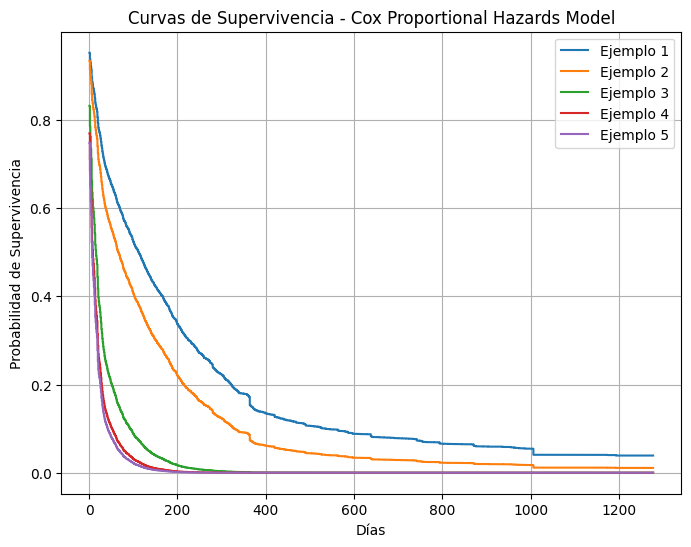

<Figure size 640x480 with 0 Axes>

In [26]:
## COX (Cox Proportional Hazards Model) ##

# Transformamos 'df_general_results' y 'df_train_test_results' al formato pd.DataFrame si es Styler
if hasattr(df_general_results, "data"):
    df_general_results = df_general_results.data.copy()
if hasattr(df_train_test_results, "data"):
    df_train_test_results = df_train_test_results.data.copy()
_ = None

# Escalamos los datos con preservación del índice
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=pd.RangeIndex(len(X_train)), columns=[f"Feature_{i}" for i in range(X_train.shape[1])])
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=pd.RangeIndex(len(X_test)), columns=[f"Feature_{i}" for i in range(X_test.shape[1])])

# Hiperparametrización COX
param_grid = {
    "l1_ratio": [0.1, 0.5, 0.9],  
    "alpha_min_ratio": [0.001, 0.01, 0.1]  
}

cox_grid = GridSearchCV(
    CoxnetSurvivalAnalysis(fit_baseline_model=True),
    param_grid,
    scoring=lambda est, X, y: concordance_index_censored(y["Evento"], y["Duración"], est.predict(X))[0],
    cv=5,
    n_jobs=-1
)

# Entrenamos el modelo con búsqueda de hiperparámetros
cox_grid.fit(X_train_scaled, y_train)

# Seleccionamos el mejor modelo
best_cox_model = cox_grid.best_estimator_

# Evaluamos el mejor modelo
c_index_test = concordance_index_censored(y_test["Evento"], y_test["Duración"], best_cox_model.predict(X_test_scaled))[0]
c_index_train = concordance_index_censored(y_train["Evento"], y_train["Duración"], best_cox_model.predict(X_train_scaled))[0]

print(f"Mejores hiperparámetros: {cox_grid.best_params_}\n")
print(f"Concordance Index (C-index) en Train: {c_index_train:.3f}")
print(f"Concordance Index (C-index) en Test: {c_index_test:.3f}\n")

# Definimos la grilla de tiempo para las predicciones
fecha_inicio = datetime(2021, 1, 1)  
fecha_fin = datetime(2024, 6, 30)  
diferencia_dias = (fecha_fin - fecha_inicio).days
time_grid = np.arange(1, diferencia_dias + 1, 1)  

# Generamos las curvas de supervivencia en Train
survival_curves_train_raw = best_cox_model.predict_survival_function(X_train_scaled)
survival_curves_train = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_train_raw]),
    index=time_grid,
    columns=X_train_scaled.index
)

# Evaluamos con SurvivalEVAL en Train
eval_COX_train = LifelinesEvaluator(survival_curves_train, y_train["Duración"], y_train["Evento"],
                                    y_train["Duración"], y_train["Evento"])
mae_COX_uncensored_train = eval_COX_train.mae(method="Uncensored")

# Generamos las curvas de supervivencia en Test
survival_curves_raw = best_cox_model.predict_survival_function(X_test_scaled)
survival_curves = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_raw]),  
    index=time_grid,  
    columns=X_test_scaled.index
)

# Evaluamos con SurvivalEVAL en Test
eval_COX = LifelinesEvaluator(survival_curves, y_test["Duración"], y_test["Evento"],
                              y_train["Duración"], y_train["Evento"])
mae_COX_uncensored_test = eval_COX.mae(method="Uncensored")

# Imprimimos valores obtenidos
print(f"MAE COX (con datos no censurados) en Train: {mae_COX_uncensored_train:.3f}")
print(f"MAE COX (con datos no censurados) en Test: {mae_COX_uncensored_test:.3f}\n")

# Guardamos el modelo y sus métricas en un diccionario 
model_metadata = {
    "modelo": best_cox_model,
    "c_index_train": c_index_train,
    "c_index_test": c_index_test,
    "mae_uncensored_train": mae_COX_uncensored_train,
    "mae_uncensored_test": mae_COX_uncensored_test,
    "hiperparametros": cox_grid.best_params_ 
}

# Guardamos el modelo entrenado en formato diccionario con los resultados de los estadísticos
output_dir = "./MODELO GENERAL"
os.makedirs(output_dir, exist_ok=True)
model_filename = os.path.join(output_dir, "Cox_Proportional_Hazards_Model.pkl")
joblib.dump(model_metadata, model_filename, compress=3)

# Guardamos los resultados en 'df_general_results'
if not ((df_general_results["Modelo"] == "Cox Proportional Hazards Model") & (df_general_results["Rubro"] == "Modelo General")).any():
    df_general_results = pd.concat([df_general_results, pd.DataFrame({
        "Rubro": ["Modelo General"],
        "Modelo": ["Cox Proportional Hazards Model"],
        "C-Index": [c_index_test],
        "MAE": [mae_COX_uncensored_test], 
        "Características": [str(cox_grid.best_params_)]
    })], ignore_index=True)

# Guardamos los resultados en 'df_train_test_results'
if not ((df_train_test_results["Modelo"] == "Cox Proportional Hazards Model") & (df_train_test_results["Rubro"] == "Modelo General")).any():
    df_train_test_results = pd.concat([df_train_test_results, pd.DataFrame({
        "Rubro": ["Modelo General"],
        "Modelo": ["Cox Proportional Hazards Model"],
        "Test_C-Index": [c_index_test], 
        "Train_C-Index": [c_index_train],
        "Test_MAE": [mae_COX_uncensored_test], 
        "Train_MAE": [mae_COX_uncensored_train] 
    })], ignore_index=True)

# Proyección de la curva de supervivencia en ejemplos de test
num_samples = 5
sample_indices = np.random.choice(X_test_scaled.shape[0], num_samples, replace=False)
X_test_sample = X_test_scaled.iloc[sample_indices]

# Visualización de las curvas de supervivencia
plt.figure(figsize=(8, 6))
for i, surv_func in enumerate(best_cox_model.predict_survival_function(X_test_sample)):
    plt.step(surv_func.x, surv_func.y, where="post", label=f"Ejemplo {i+1}")

plt.xlabel("Días")
plt.ylabel("Probabilidad de Supervivencia")
plt.title("Curvas de Supervivencia - Cox Proportional Hazards Model")
plt.legend()
plt.grid()
plt.show()

# Guardamos la imagen de las curvas de supervivencia
image_filename = os.path.join(output_dir, "Cox_Proportional_Hazards_Model_Curva_de_Supervivencia.png")
plt.savefig(image_filename, dpi=300, bbox_inches="tight")

In [28]:
## ANÁLISIS NUMÉRICO DE OVERFITTING PARA COX (Cox Proportional Hazards Model) ##

# Definimos el tamaño de la muestra como el 30% del conjunto de entrenamiento
sample_size = int(0.3 * len(X_train))

# Seleccionamos índices aleatorios para la muestra en train y test
sample_indices_train = np.random.choice(X_train_scaled.index, sample_size, replace=False)
sample_indices_test = np.random.choice(X_test_scaled.index, sample_size, replace=False)

# Evaluamos en muestras reducidas utilizando el modelo Cox entrenado
c_index_train = concordance_index_censored(
    y_train[sample_indices_train]["Evento"],  
    y_train[sample_indices_train]["Duración"], 
    best_cox_model.predict(X_train_scaled.iloc[sample_indices_train])
)[0]

c_index_test = concordance_index_censored(
    y_test[sample_indices_test]["Evento"],  
    y_test[sample_indices_test]["Duración"], 
    best_cox_model.predict(X_test_scaled.iloc[sample_indices_test])
)[0]

# Imprimimos resultados
print(f"\nConcordance Index (C-index) en Train (30% muestra): {c_index_train:.3f}")
print(f"Concordance Index (C-index) en Test (30% muestra): {c_index_test:.3f}")

# Comparación de resultados
if c_index_train - c_index_test > 0.05:
    print("Posible Overfitting: El modelo tiene un mejor desempeño en entrenamiento que en prueba.")
else:
    print("\nNo hay signos evidentes de Overfitting.")


Concordance Index (C-index) en Train (30% muestra): 0.708
Concordance Index (C-index) en Test (30% muestra): 0.707

No hay signos evidentes de Overfitting.


#### **2.1.2**   **<ins>Random Survival Forest</ins>**

Hiperparámetros del Modelo RSF: {'n_estimators': 1200, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 10, 'random_state': 42, 'n_jobs': -1}

Concordance Index (C-index) en Train: 0.731
Concordance Index (C-index) en Test: 0.729

MAE RSF (con datos no censurados) en Train: 32.713
MAE RSF (con datos no censurados) en Test: 33.104



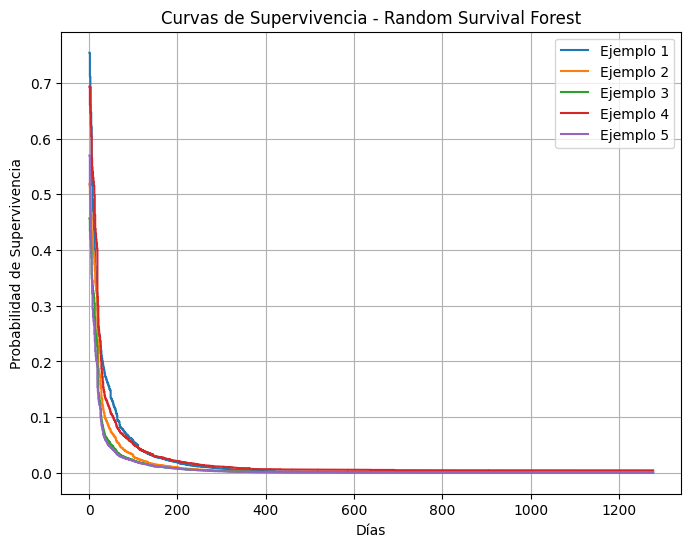

<Figure size 640x480 with 0 Axes>

In [29]:
## RANDOM SURVIVAL FOREST ##

# Transformamos 'df_general_results' y 'df_train_test_results' al formato pd.DataFrame si es Styler
if hasattr(df_general_results, "data"):
    df_general_results = df_general_results.data.copy()
if hasattr(df_train_test_results, "data"):
    df_train_test_results = df_train_test_results.data.copy()
_ = None

# Escalamos los datos con preservación del índice
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=pd.RangeIndex(len(X_train)), columns=[f"Feature_{i}" for i in range(X_train.shape[1])])
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=pd.RangeIndex(len(X_test)), columns=[f"Feature_{i}" for i in range(X_test.shape[1])])

# Definimos los hiperparámetros del modelo
rsf_params = {
    "n_estimators": 1200,
    "min_samples_split": 6,
    "min_samples_leaf": 8,
    "max_features": "sqrt",
    "max_depth": 10,
    "random_state": 42,
    "n_jobs": -1
}

# Entrenamos el modelo directamente con los datos de entrenamiento
best_rsf_model = RandomSurvivalForest(**rsf_params)
best_rsf_model.fit(X_train_scaled, y_train)

# Evaluamos el modelo con Concordance Index
c_index_test = concordance_index_censored(y_test["Evento"], y_test["Duración"], best_rsf_model.predict(X_test_scaled))[0]
c_index_train = concordance_index_censored(y_train["Evento"], y_train["Duración"], best_rsf_model.predict(X_train_scaled))[0]

print(f"Hiperparámetros del Modelo RSF: {rsf_params}\n")
print(f"Concordance Index (C-index) en Train: {c_index_train:.3f}")
print(f"Concordance Index (C-index) en Test: {c_index_test:.3f}\n")

# Definimos la grilla de tiempo para las predicciones
fecha_inicio = datetime(2021, 1, 1)
fecha_fin = datetime(2024, 6, 30)
diferencia_dias = (fecha_fin - fecha_inicio).days
time_grid = np.arange(1, diferencia_dias + 1, 1)

# Generamos las curvas de supervivencia en Train
survival_curves_train_raw = best_rsf_model.predict_survival_function(X_train_scaled)
survival_curves_train = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_train_raw]),
    index=time_grid,
    columns=X_train_scaled.index
)

# Evaluamos con SurvivalEVAL en Train
eval_RSF_train = LifelinesEvaluator(survival_curves_train, y_train["Duración"], y_train["Evento"],
                                    y_train["Duración"], y_train["Evento"])
mae_RSF_uncensored_train = eval_RSF_train.mae(method="Uncensored")

# Generamos las curvas de supervivencia en Test
survival_curves_raw = best_rsf_model.predict_survival_function(X_test_scaled)
survival_curves = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_raw]),  
    index=time_grid,  
    columns=X_test_scaled.index
)

# Evaluamos con SurvivalEVAL en Test
eval_RSF = LifelinesEvaluator(survival_curves, y_test["Duración"], y_test["Evento"],
                              y_train["Duración"], y_train["Evento"])
mae_RSF_uncensored_test = eval_RSF.mae(method="Uncensored")

# Imprimimos valores obtenidos
print(f"MAE RSF (con datos no censurados) en Train: {mae_RSF_uncensored_train:.3f}")
print(f"MAE RSF (con datos no censurados) en Test: {mae_RSF_uncensored_test:.3f}\n")

# Guardamos el modelo y sus métricas en un diccionario 
model_metadata_rsf = {
    "modelo": best_rsf_model,
    "c_index_train": c_index_train,
    "c_index_test": c_index_test,
    "mae_uncensored_train": mae_RSF_uncensored_train,
    "mae_uncensored_test": mae_RSF_uncensored_test,
    "hiperparametros": rsf_params
}

# Guardamos el modelo entrenado en formato diccionario con los resultados de los estadísticos
output_dir = "./MODELO GENERAL"
os.makedirs(output_dir, exist_ok=True)
model_filename = os.path.join(output_dir, "Random_Survival_Forest.pkl")
joblib.dump(model_metadata_rsf, model_filename, compress=3)

# Guardamos los resultados en 'df_general_results'
if not ((df_general_results["Modelo"] == "Random Survival Forest") & (df_general_results["Rubro"] == "Modelo General")).any():
    df_general_results = pd.concat([df_general_results, pd.DataFrame({
        "Rubro": ["Modelo General"],
        "Modelo": ["Random Survival Forest"],
        "C-Index": [c_index_test],
        "MAE": [mae_RSF_uncensored_test], 
        "Características": [str(rsf_params)]
    })], ignore_index=True)

# Guardamos los resultados en 'df_train_test_results' 
if not ((df_train_test_results["Modelo"] == "Random Survival Forest") & (df_train_test_results["Rubro"] == "Modelo General")).any():
    df_train_test_results = pd.concat([df_train_test_results, pd.DataFrame({
        "Rubro": ["Modelo General"],
        "Modelo": ["Random Survival Forest"],
        "Test_C-Index": [c_index_test], 
        "Train_C-Index": [c_index_train],
        "Test_MAE": [mae_RSF_uncensored_test], 
        "Train_MAE": [mae_RSF_uncensored_train] 
    })], ignore_index=True)

# Proyección de la curva de supervivencia en ejemplos de test
num_samples = 5
sample_indices = np.random.choice(X_test_scaled.shape[0], num_samples, replace=False)
X_test_sample = X_test_scaled.iloc[sample_indices]

# Visualización de las curvas de supervivencia
plt.figure(figsize=(8, 6))
for i, surv_func in enumerate(best_rsf_model.predict_survival_function(X_test_sample)):
    plt.step(surv_func.x, surv_func.y, where="post", label=f"Ejemplo {i+1}")

plt.xlabel("Días")
plt.ylabel("Probabilidad de Supervivencia")
plt.title("Curvas de Supervivencia - Random Survival Forest")
plt.legend()
plt.grid()
plt.show()

# Guardamos la imagen de las curvas de supervivencia
image_filename = os.path.join(output_dir, "Random_Survival_Forest_Curva_de_Supervivencia.png")
plt.savefig(image_filename, dpi=300, bbox_inches="tight")

In [41]:
## ANÁLISIS NUMÉRICO DE OVERFITTING PARA SURVIVAL RANDOM FOREST ##

# Extraemos el modelo y sus métricas del diccionario
best_rsf_model = model_metadata_rsf.get("modelo", None)  # Ahora el modelo cargado se llama best_rsf_model

# Verificación de que el modelo fue cargado correctamente
if best_rsf_model is None:
    raise ValueError("El modelo Random Survival Forest no se cargó correctamente.")

# Tomamos una muestra del 30% de los datos para evaluación
sample_size = int(0.3 * len(X_train))
sample_indices_train = np.random.choice(len(X_train), sample_size, replace=False)
sample_indices_test = np.random.choice(len(X_test), sample_size, replace=False)

# Evaluación en muestras reducidas
c_index_train = concordance_index_censored(
    y_train[sample_indices_train]["Evento"], 
    y_train[sample_indices_train]["Duración"], 
    best_rsf_model.predict(X_train[sample_indices_train])
)[0]

c_index_test = concordance_index_censored(
    y_test[sample_indices_test]["Evento"], 
    y_test[sample_indices_test]["Duración"], 
    best_rsf_model.predict(X_test[sample_indices_test])
)[0]

# Imprimimos resultados
print(f"\nConcordance Index (C-index) en Train (30% muestra): {c_index_train:.3f}")
print(f"Concordance Index (C-index) en Test (30% muestra): {c_index_test:.3f}")

# Comparación de resultados
if c_index_train - c_index_test > 0.05:
    print("Posible Overfitting: El modelo tiene mucho mejor desempeño en entrenamiento que en prueba.")
else:
    print("No hay signos evidentes de Overfitting.")


Concordance Index (C-index) en Train (30% muestra): 0.640
Concordance Index (C-index) en Test (30% muestra): 0.641
No hay signos evidentes de Overfitting.


### **2.2** **<ins>Modelización por Rubro</ins>**

#### **2.2.1**   **<ins>Alimentos</ins>**

In [42]:
### DEFINICIÓN DEL CONJUNTO PARA ALIMENTOS ####

# Filtramos solo los registros del rubro "Alimentos"
df_alimentos = df_price_spells[df_price_spells["Rubro"] == "Alimentos"].copy()

# Convertimos el DataFrame al formato de supervivencia
y_alimentos = Surv.from_dataframe("Evento", time_variable, df_alimentos)
encoder_alimentos = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Aplicamos el OneHotEncoder a las variables categóricas
X_cat_alimentos = encoder_alimentos.fit_transform(df_alimentos[categorical_columns])

# Extraemos las variables numéricas
X_num_alimentos = df_alimentos[numeric_columns].values

# Concatenamos ambas partes para formar la matriz final de predictores
X_final_alimentos = np.concatenate([X_cat_alimentos, X_num_alimentos], axis=1)

# Dividimos en 70% Train y 30% Test directamente
X_train_alimentos, X_test_alimentos, y_train_alimentos, y_test_alimentos = train_test_split(
    X_final_alimentos, y_alimentos, test_size=0.3, random_state=42
)

# Verificamos los tamaños de cada conjunto
total_registros_alimentos = X_final_alimentos.shape[0]
print(f"Tamaño del conjunto de entrenamiento: {X_train_alimentos.shape[0]} ({(X_train_alimentos.shape[0] / total_registros_alimentos) * 100:.2f}%)")
print(f"Tamaño del conjunto de prueba: {X_test_alimentos.shape[0]} ({(X_test_alimentos.shape[0] / total_registros_alimentos) * 100:.2f}%)")

Tamaño del conjunto de entrenamiento: 143076 (70.00%)
Tamaño del conjunto de prueba: 61319 (30.00%)


##### **2.2.1.1** **<ins>Cox</ins>** ***(Cox Proportional Hazards Model)***

Mejores hiperparámetros para Alimentos: {'alpha_min_ratio': 0.001, 'l1_ratio': 0.1}

Concordance Index (C-index) para Alimentos en Train: 0.652
Concordance Index (C-index) para Alimentos en Test: 0.653

MAE COX (con datos no censurados) para Alimentos en Train: 32.968
MAE COX (con datos no censurados) para Aliemtos en Test: 33.351



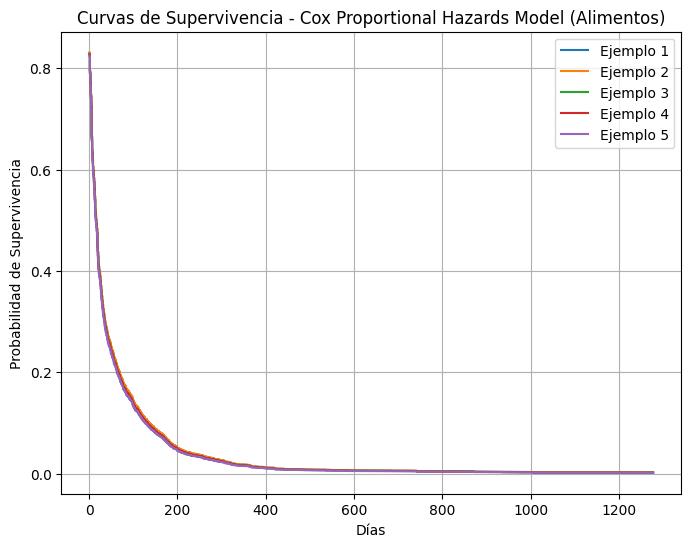

<Figure size 640x480 with 0 Axes>

In [43]:
## COX (Cox Proportional Hazards Model) PARA ALIMENTOS ##

# Transformamos 'df_general_results' y 'df_train_test_results' al formato pd.DataFrame si es Styler
if hasattr(df_general_results, "data"):
    df_general_results = df_general_results.data.copy()
if hasattr(df_train_test_results, "data"):
    df_train_test_results = df_train_test_results.data.copy()
_ = None

# Escalamos los datos con preservación del índice
scaler = StandardScaler()
X_train_alimentos_scaled = pd.DataFrame(scaler.fit_transform(X_train_alimentos), index=pd.RangeIndex(len(X_train_alimentos)), columns=[f"Feature_{i}" for i in range(X_train_alimentos.shape[1])])
X_test_alimentos_scaled = pd.DataFrame(scaler.transform(X_test_alimentos), index=pd.RangeIndex(len(X_test_alimentos)), columns=[f"Feature_{i}" for i in range(X_test_alimentos.shape[1])])

# Hiperparametrización COX
param_grid = {
    "l1_ratio": [0.1, 0.5, 0.9],  
    "alpha_min_ratio": [0.001, 0.01, 0.1]  
}

cox_grid = GridSearchCV(
    CoxnetSurvivalAnalysis(fit_baseline_model=True),
    param_grid,
    scoring=lambda est, X, y: concordance_index_censored(y["Evento"], y["Duración"], est.predict(X))[0],
    cv=5,
    n_jobs=-1
)

# Entrenamos el modelo con búsqueda de hiperparámetros
cox_grid.fit(X_train_alimentos_scaled, y_train_alimentos)

# Seleccionamos el mejor modelo
best_cox_model_alimentos = cox_grid.best_estimator_

# Evaluamos el mejor modelo
c_index_test_alimentos = concordance_index_censored(y_test_alimentos["Evento"], y_test_alimentos["Duración"], best_cox_model_alimentos.predict(X_test_alimentos_scaled))[0]
c_index_train_alimentos = concordance_index_censored(y_train_alimentos["Evento"], y_train_alimentos["Duración"], best_cox_model_alimentos.predict(X_train_alimentos_scaled))[0]

print(f"Mejores hiperparámetros para Alimentos: {cox_grid.best_params_}\n")
print(f"Concordance Index (C-index) para Alimentos en Train: {c_index_train_alimentos:.3f}")
print(f"Concordance Index (C-index) para Alimentos en Test: {c_index_test_alimentos:.3f}\n")

# Definimos la grilla de tiempo para las predicciones
fecha_inicio = datetime(2021, 1, 1)  
fecha_fin = datetime(2024, 6, 30)  
diferencia_dias = (fecha_fin - fecha_inicio).days
time_grid = np.arange(1, diferencia_dias + 1, 1)  

# Generamos las curvas de supervivencia en Train
survival_curves_train_raw = best_cox_model_alimentos.predict_survival_function(X_train_alimentos_scaled)
survival_curves_train = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_train_raw]),
    index=time_grid,
    columns=X_train_alimentos_scaled.index
)

# Evaluamos con SurvivalEVAL en Train
eval_COX_train = LifelinesEvaluator(survival_curves_train, y_train_alimentos["Duración"], y_train_alimentos["Evento"],
                                    y_train_alimentos["Duración"], y_train_alimentos["Evento"])
mae_COX_uncensored_train_alimentos = eval_COX_train.mae(method="Uncensored")

# Generamos las curvas de supervivencia en Test
survival_curves_raw = best_cox_model_alimentos.predict_survival_function(X_test_alimentos_scaled)
survival_curves = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_raw]),  
    index=time_grid,  
    columns=X_test_alimentos_scaled.index
)

# Evaluamos con SurvivalEVAL en Test
eval_COX = LifelinesEvaluator(survival_curves, y_test_alimentos["Duración"], y_test_alimentos["Evento"],
                              y_train_alimentos["Duración"], y_train_alimentos["Evento"])
mae_COX_uncensored_test_alimentos = eval_COX.mae(method="Uncensored")

# Imprimimos valores obtenidos
print(f"MAE COX (con datos no censurados) para Alimentos en Train: {mae_COX_uncensored_train_alimentos:.3f}")
print(f"MAE COX (con datos no censurados) para Aliemtos en Test: {mae_COX_uncensored_test_alimentos:.3f}\n")

# Guardamos el modelo y sus métricas en un diccionario 
model_metadata_alimentos = {
    "modelo": best_cox_model_alimentos,
    "c_index_train": c_index_train_alimentos,
    "c_index_test": c_index_test_alimentos,
    "mae_uncensored_train": mae_COX_uncensored_train_alimentos,
    "mae_uncensored_test": mae_COX_uncensored_test_alimentos,
    "hiperparametros": cox_grid.best_params_ 
}

# Guardamos el modelo entrenado en formato diccionario con los resultados de los estadísticos
output_dir = "./ALIMENTOS"
os.makedirs(output_dir, exist_ok=True)
model_filename = os.path.join(output_dir, "Cox_Proportional_Hazards_Model_Alimentos.pkl")
joblib.dump(model_metadata_alimentos, model_filename, compress=3)

# Guardamos los resultados en 'df_general_results'
if not ((df_general_results["Modelo"] == "Cox Proportional Hazards Model") & (df_general_results["Rubro"] == "Alimentos")).any():
    df_general_results = pd.concat([df_general_results, pd.DataFrame({
        "Rubro": ["Alimentos"],
        "Modelo": ["Cox Proportional Hazards Model"],
        "C-Index": [c_index_test_alimentos],
        "MAE": [mae_COX_uncensored_test_alimentos], 
        "Características": [str(cox_grid.best_params_)]
    })], ignore_index=True)

# Guardamos los resultados en 'df_train_test_results'
if not ((df_train_test_results["Modelo"] == "Cox Proportional Hazards Model") & (df_train_test_results["Rubro"] == "Alimentos")).any():
    df_train_test_results = pd.concat([df_train_test_results, pd.DataFrame({
        "Rubro": ["Alimentos"],
        "Modelo": ["Cox Proportional Hazards Model"],
        "Test_C-Index": [c_index_test_alimentos], 
        "Train_C-Index": [c_index_train_alimentos],
        "Test_MAE": [mae_COX_uncensored_test_alimentos], 
        "Train_MAE": [mae_COX_uncensored_train_alimentos] 
    })], ignore_index=True)

# Proyección de la curva de supervivencia en ejemplos de test
num_samples = 5
sample_indices = np.random.choice(X_test_alimentos_scaled.shape[0], num_samples, replace=False)
X_test_sample = X_test_alimentos_scaled.iloc[sample_indices]

# Visualización de las curvas de supervivencia
plt.figure(figsize=(8, 6))
for i, surv_func in enumerate(best_cox_model_alimentos.predict_survival_function(X_test_sample)):
    plt.step(surv_func.x, surv_func.y, where="post", label=f"Ejemplo {i+1}")

plt.xlabel("Días")
plt.ylabel("Probabilidad de Supervivencia")
plt.title("Curvas de Supervivencia - Cox Proportional Hazards Model (Alimentos)")
plt.legend()
plt.grid()
plt.show()

# Guardamos la imagen de las curvas de supervivencia
image_filename = os.path.join(output_dir, "Cox_Proportional_Hazards_Model_Curva_de_Supervivencia_Alimentos.png")
plt.savefig(image_filename, dpi=300, bbox_inches="tight")

In [45]:
## ANÁLISIS NUMÉRICO DE OVERFITTING PARA COX (Cox Proportional Hazards Model) (ALIMENTOS) ##

# Evaluamos el modelo en el conjunto completo de entrenamiento y prueba
c_index_train_alimentos = concordance_index_censored(
    y_train_alimentos["Evento"],  
    y_train_alimentos["Duración"], 
    best_cox_model_alimentos.predict(X_train_alimentos_scaled)
)[0]

c_index_test_alimentos = concordance_index_censored(
    y_test_alimentos["Evento"],  
    y_test_alimentos["Duración"], 
    best_cox_model_alimentos.predict(X_test_alimentos_scaled)
)[0]

# Imprimimos resultados
print(f"\nConcordance Index (C-index) para Alimentos en Train: {c_index_train_alimentos:.3f}")
print(f"Concordance Index (C-index) para Alimentos en Test: {c_index_test_alimentos:.3f}")

# Comparación de resultados
if c_index_train_alimentos - c_index_test_alimentos > 0.05:
    print("Posible Overfitting: El modelo tiene un mejor desempeño en entrenamiento que en prueba para Alimentos.")
else:
    print("No hay signos evidentes de Overfitting en Alimentos.")


Concordance Index (C-index) para Alimentos en Train: 0.652
Concordance Index (C-index) para Alimentos en Test: 0.653
No hay signos evidentes de Overfitting en Alimentos.


##### **2.2.1.2**   **<ins>Random Survival Forest</ins>**

Hiperparámetros del Modelo RSF para Alimentos: {'n_estimators': 500, 'min_samples_split': 12, 'min_samples_leaf': 25, 'max_features': 'log2', 'max_depth': 12, 'random_state': 42, 'n_jobs': -1}

Concordance Index (C-index) en Train para Alimentos: 0.731
Concordance Index (C-index) en Test para Alimentos: 0.731

MAE RSF (con datos no censurados) en Train para Alimentos: 26.391
MAE RSF (con datos no censurados) en Test para Alimentos: 26.733



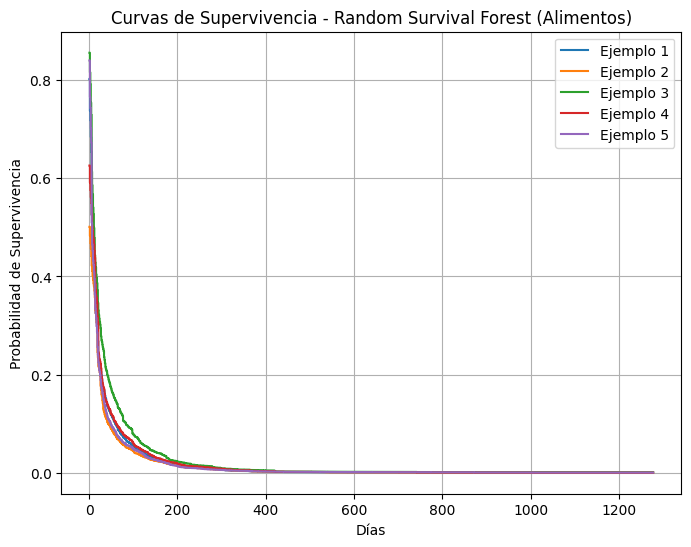

<Figure size 640x480 with 0 Axes>

In [46]:
## RANDOM SURVIVAL FOREST PARA ALIMENTOS ##

# Transformamos 'df_general_results' y 'df_train_test_results' al formato pd.DataFrame si es Styler
if hasattr(df_general_results, "data"):
    df_general_results = df_general_results.data.copy()
if hasattr(df_train_test_results, "data"):
    df_train_test_results = df_train_test_results.data.copy()
_ = None

# Escalamos los datos con preservación del índice
scaler = StandardScaler()
X_train_alimentos_scaled = pd.DataFrame(scaler.fit_transform(X_train_alimentos), index=pd.RangeIndex(len(X_train_alimentos)), columns=[f"Feature_{i}" for i in range(X_train_alimentos.shape[1])])
X_test_alimentos_scaled = pd.DataFrame(scaler.transform(X_test_alimentos), index=pd.RangeIndex(len(X_test_alimentos)), columns=[f"Feature_{i}" for i in range(X_test_alimentos.shape[1])])

# Definimos los hiperparámetros del modelo
rsf_params_alimentos = {
    "n_estimators": 500,
    "min_samples_split": 12,
    "min_samples_leaf": 25,
    "max_features": "log2",
    "max_depth": 12,
    "random_state": 42,
    "n_jobs": -1
}

# Entrenamos el modelo directamente con los datos de entrenamiento
best_rsf_model_alimentos = RandomSurvivalForest(**rsf_params_alimentos)
best_rsf_model_alimentos.fit(X_train_alimentos_scaled, y_train_alimentos)

# Evaluamos el modelo con Concordance Index
c_index_test_alimentos = concordance_index_censored(y_test_alimentos["Evento"], y_test_alimentos["Duración"], best_rsf_model_alimentos.predict(X_test_alimentos_scaled))[0]
c_index_train_alimentos = concordance_index_censored(y_train_alimentos["Evento"], y_train_alimentos["Duración"], best_rsf_model_alimentos.predict(X_train_alimentos_scaled))[0]

print(f"Hiperparámetros del Modelo RSF para Alimentos: {rsf_params_alimentos}\n")
print(f"Concordance Index (C-index) en Train para Alimentos: {c_index_train_alimentos:.3f}")
print(f"Concordance Index (C-index) en Test para Alimentos: {c_index_test_alimentos:.3f}\n")

# Definimos la grilla de tiempo para las predicciones
fecha_inicio = datetime(2021, 1, 1)
fecha_fin = datetime(2024, 6, 30)
diferencia_dias = (fecha_fin - fecha_inicio).days
time_grid = np.arange(1, diferencia_dias + 1, 1)

# Generamos las curvas de supervivencia en Train
survival_curves_train_raw = best_rsf_model_alimentos.predict_survival_function(X_train_alimentos_scaled)
survival_curves_train = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_train_raw]),
    index=time_grid,
    columns=X_train_alimentos_scaled.index
)

# Evaluamos con SurvivalEVAL en Train
eval_RSF_train = LifelinesEvaluator(survival_curves_train, y_train_alimentos["Duración"], y_train_alimentos["Evento"],
                                    y_train_alimentos["Duración"], y_train_alimentos["Evento"])
mae_RSF_uncensored_train_alimentos = eval_RSF_train.mae(method="Uncensored")

# Generamos las curvas de supervivencia en Test
survival_curves_raw = best_rsf_model_alimentos.predict_survival_function(X_test_alimentos_scaled)
survival_curves = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_raw]),  
    index=time_grid,  
    columns=X_test_alimentos_scaled.index
)

# Evaluamos con SurvivalEVAL en Test
eval_RSF = LifelinesEvaluator(survival_curves, y_test_alimentos["Duración"], y_test_alimentos["Evento"],
                              y_train_alimentos["Duración"], y_train_alimentos["Evento"])
mae_RSF_uncensored_test_alimentos = eval_RSF.mae(method="Uncensored")

# Imprimimos valores obtenidos
print(f"MAE RSF (con datos no censurados) en Train para Alimentos: {mae_RSF_uncensored_train_alimentos:.3f}")
print(f"MAE RSF (con datos no censurados) en Test para Alimentos: {mae_RSF_uncensored_test_alimentos:.3f}\n")

# Guardamos el modelo y sus métricas en un diccionario 
model_metadata_rsf_alimentos = {
    "modelo": best_rsf_model_alimentos,
    "c_index_train": c_index_train_alimentos,
    "c_index_test": c_index_test_alimentos,
    "mae_uncensored_train": mae_RSF_uncensored_train_alimentos,
    "mae_uncensored_test": mae_RSF_uncensored_test_alimentos,
    "hiperparametros": rsf_params_alimentos
}

# Guardamos el modelo entrenado en formato diccionario con los resultados de los estadísticos
output_dir = "./ALIMENTOS"
os.makedirs(output_dir, exist_ok=True)
model_filename = os.path.join(output_dir, "Random_Survival_Forest_Alimentos.pkl")
joblib.dump(model_metadata_rsf_alimentos, model_filename, compress=3)

# Guardamos los resultados en 'df_general_results'
if not ((df_general_results["Modelo"] == "Random Survival Forest") & (df_general_results["Rubro"] == "Alimentos")).any():
    df_general_results = pd.concat([df_general_results, pd.DataFrame({
        "Rubro": ["Alimentos"],
        "Modelo": ["Random Survival Forest"],
        "C-Index": [c_index_test_alimentos],
        "MAE": [mae_RSF_uncensored_test_alimentos], 
        "Características": [str(rsf_params_alimentos)]
    })], ignore_index=True)

# Guardamos los resultados en 'df_train_test_results' 
if not ((df_train_test_results["Modelo"] == "Random Survival Forest") & (df_train_test_results["Rubro"] == "Alimentos")).any():
    df_train_test_results = pd.concat([df_train_test_results, pd.DataFrame({
        "Rubro": ["Alimentos"],
        "Modelo": ["Random Survival Forest"],
        "Test_C-Index": [c_index_test_alimentos], 
        "Train_C-Index": [c_index_train_alimentos],
        "Test_MAE": [mae_RSF_uncensored_test_alimentos], 
        "Train_MAE": [mae_RSF_uncensored_train_alimentos] 
    })], ignore_index=True)

# Proyección de la curva de supervivencia en ejemplos de test
num_samples = 5
sample_indices = np.random.choice(X_test_alimentos_scaled.shape[0], num_samples, replace=False)
X_test_sample = X_test_alimentos_scaled.iloc[sample_indices]

# Visualización de las curvas de supervivencia
plt.figure(figsize=(8, 6))
for i, surv_func in enumerate(best_rsf_model_alimentos.predict_survival_function(X_test_sample)):
    plt.step(surv_func.x, surv_func.y, where="post", label=f"Ejemplo {i+1}")

plt.xlabel("Días")
plt.ylabel("Probabilidad de Supervivencia")
plt.title("Curvas de Supervivencia - Random Survival Forest (Alimentos)")
plt.legend()
plt.grid()
plt.show()

# Guardamos la imagen de las curvas de supervivencia
image_filename = os.path.join(output_dir, "Random_Survival_Forest_Curva_de_Supervivencia_Alimentos.png")
plt.savefig(image_filename, dpi=300, bbox_inches="tight")

In [48]:
## ANÁLISIS NUMÉRICO DE OVERFITTING PARA SURVIVAL RANDOM FOREST (ALIMENTOS) ##

# Evaluamos el modelo en el conjunto completo de entrenamiento y prueba
c_index_train_alimentos = concordance_index_censored(
    y_train_alimentos["Evento"],  
    y_train_alimentos["Duración"], 
    best_rsf_model_alimentos.predict(X_train_alimentos)
)[0]

c_index_test_alimentos = concordance_index_censored(
    y_test_alimentos["Evento"],  
    y_test_alimentos["Duración"], 
    best_rsf_model_alimentos.predict(X_test_alimentos)
)[0]

# Imprimimos resultados
print(f"\nConcordance Index (C-index) para Alimentos en Train: {c_index_train_alimentos:.3f}")
print(f"Concordance Index (C-index) para Alimentos en Test: {c_index_test_alimentos:.3f}")

# Comparación de resultados
if c_index_train_alimentos - c_index_test_alimentos > 0.05:
    print("Posible Overfitting: El modelo tiene un mejor desempeño en entrenamiento que en prueba para Alimentos.")
else:
    print("No hay signos evidentes de Overfitting en Alimentos.")


Concordance Index (C-index) para Alimentos en Train: 0.656
Concordance Index (C-index) para Alimentos en Test: 0.658
No hay signos evidentes de Overfitting en Alimentos.


#### **2.2.2**   **<ins>Bebidas con Alcohol</ins>**

In [49]:
### DEFINICIÓN DEL CONJUNTO PARA BEBIDAS CON ALCOHOL ###

# Filtramos solo los registros del rubro "Bebidas con Alcohol"
df_bebidas_con_alcohol = df_price_spells[df_price_spells["Rubro"] == "Bebidas con Alcohol"].copy()

# Convertimos el DataFrame al formato de supervivencia
y_bebidas_con_alcohol = Surv.from_dataframe("Evento", time_variable, df_bebidas_con_alcohol)
encoder_bebidas_con_alcohol = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Aplicamos el OneHotEncoder a las variables categóricas
X_cat_bebidas_con_alcohol = encoder_bebidas_con_alcohol.fit_transform(df_bebidas_con_alcohol[categorical_columns])

# Extraemos las variables numéricas
X_num_bebidas_con_alcohol = df_bebidas_con_alcohol[numeric_columns].values

# Concatenamos ambas partes para formar la matriz final de predictores
X_final_bebidas_con_alcohol = np.concatenate([X_cat_bebidas_con_alcohol, X_num_bebidas_con_alcohol], axis=1)

# Dividimos en 70% Train y 30% Test directamente
X_train_bebidas_con_alcohol, X_test_bebidas_con_alcohol, y_train_bebidas_con_alcohol, y_test_bebidas_con_alcohol = train_test_split(
    X_final_bebidas_con_alcohol, y_bebidas_con_alcohol, test_size=0.3, random_state=42
)

# Verificamos los tamaños de cada conjunto
total_registros_bebidas_con_alcohol = X_final_bebidas_con_alcohol.shape[0]
print(f"Tamaño del conjunto de entrenamiento: {X_train_bebidas_con_alcohol.shape[0]} ({(X_train_bebidas_con_alcohol.shape[0] / total_registros_bebidas_con_alcohol) * 100:.2f}%)")
print(f"Tamaño del conjunto de prueba: {X_test_bebidas_con_alcohol.shape[0]} ({(X_test_bebidas_con_alcohol.shape[0] / total_registros_bebidas_con_alcohol) * 100:.2f}%)")

Tamaño del conjunto de entrenamiento: 11578 (70.00%)
Tamaño del conjunto de prueba: 4962 (30.00%)


##### **2.2.2.1** **<ins>Cox</ins>** ***(Cox Proportional Hazards Model)***

Mejores hiperparámetros para Bebidas con Alcohol: {'alpha_min_ratio': 0.001, 'l1_ratio': 0.5}

Concordance Index (C-index) para Bebidas con Alcohol en Train: 0.693
Concordance Index (C-index) para Bebidas con Alcohol en Test: 0.696

MAE COX (con datos no censurados) para Bebidas con Alcohol en Train: 42.613
MAE COX (con datos no censurados) para Bebidas con Alcohol en Test: 36.438



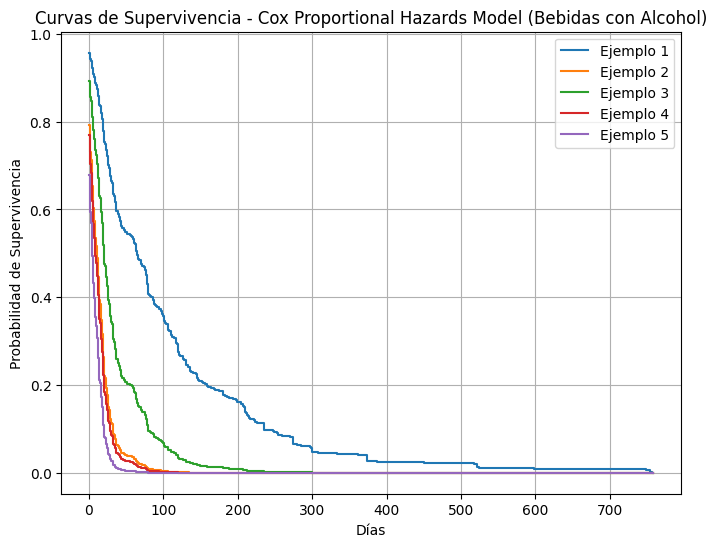

<Figure size 640x480 with 0 Axes>

In [50]:
## COX (Cox Proportional Hazards Model) PARA BEBIDAS CON ALCOHOL ##

# Transformamos 'df_general_results' y 'df_train_test_results' al formato pd.DataFrame si es Styler
if hasattr(df_general_results, "data"):
    df_general_results = df_general_results.data.copy()
if hasattr(df_train_test_results, "data"):
    df_train_test_results = df_train_test_results.data.copy()
_ = None

# Escalamos los datos con preservación del índice
scaler = StandardScaler()
X_train_bebidas_con_alcohol_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_bebidas_con_alcohol), 
    index=pd.RangeIndex(len(X_train_bebidas_con_alcohol)), 
    columns=[f"Feature_{i}" for i in range(X_train_bebidas_con_alcohol.shape[1])]
)
X_test_bebidas_con_alcohol_scaled = pd.DataFrame(
    scaler.transform(X_test_bebidas_con_alcohol), 
    index=pd.RangeIndex(len(X_test_bebidas_con_alcohol)), 
    columns=[f"Feature_{i}" for i in range(X_test_bebidas_con_alcohol.shape[1])]
)

# Hiperparametrización COX
param_grid = {
    "l1_ratio": [0.1, 0.5, 0.9],  
    "alpha_min_ratio": [0.001, 0.01, 0.1]  
}

cox_grid = GridSearchCV(
    CoxnetSurvivalAnalysis(fit_baseline_model=True),
    param_grid,
    scoring=lambda est, X, y: concordance_index_censored(y["Evento"], y["Duración"], est.predict(X))[0],
    cv=5,
    n_jobs=-1
)

# Entrenamos el modelo con búsqueda de hiperparámetros
cox_grid.fit(X_train_bebidas_con_alcohol_scaled, y_train_bebidas_con_alcohol)

# Seleccionamos el mejor modelo
best_cox_model_bebidas_con_alcohol = cox_grid.best_estimator_

# Evaluamos el mejor modelo
c_index_test_bebidas_con_alcohol = concordance_index_censored(
    y_test_bebidas_con_alcohol["Evento"],  
    y_test_bebidas_con_alcohol["Duración"], 
    best_cox_model_bebidas_con_alcohol.predict(X_test_bebidas_con_alcohol_scaled)
)[0]

c_index_train_bebidas_con_alcohol = concordance_index_censored(
    y_train_bebidas_con_alcohol["Evento"],  
    y_train_bebidas_con_alcohol["Duración"], 
    best_cox_model_bebidas_con_alcohol.predict(X_train_bebidas_con_alcohol_scaled)
)[0]

print(f"Mejores hiperparámetros para Bebidas con Alcohol: {cox_grid.best_params_}\n")
print(f"Concordance Index (C-index) para Bebidas con Alcohol en Train: {c_index_train_bebidas_con_alcohol:.3f}")
print(f"Concordance Index (C-index) para Bebidas con Alcohol en Test: {c_index_test_bebidas_con_alcohol:.3f}\n")

# Definimos la grilla de tiempo para las predicciones
fecha_inicio = datetime(2021, 1, 1)  
fecha_fin = datetime(2024, 6, 30)  
diferencia_dias = (fecha_fin - fecha_inicio).days

# Ajustamos el rango de tiempo permitido
survival_curves_train_raw = best_cox_model_bebidas_con_alcohol.predict_survival_function(X_train_bebidas_con_alcohol_scaled)

# Obtenemos el tiempo máximo permitido
max_time = min([func.x.max() for func in survival_curves_train_raw])

# Restringimos time_grid dentro del rango permitido
time_grid = np.arange(1, min(diferencia_dias, max_time) + 1, 1)

# Generamos las curvas de supervivencia en Train
survival_curves_train = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_train_raw]),
    index=time_grid,
    columns=X_train_bebidas_con_alcohol_scaled.index
)

# Evaluamos con SurvivalEVAL en Train
eval_COX_train = LifelinesEvaluator(
    survival_curves_train, 
    y_train_bebidas_con_alcohol["Duración"], 
    y_train_bebidas_con_alcohol["Evento"],
    y_train_bebidas_con_alcohol["Duración"], 
    y_train_bebidas_con_alcohol["Evento"]
)
mae_COX_uncensored_train_bebidas_con_alcohol = eval_COX_train.mae(method="Uncensored")

# Generamos las curvas de supervivencia en Test
survival_curves_raw = best_cox_model_bebidas_con_alcohol.predict_survival_function(X_test_bebidas_con_alcohol_scaled)
survival_curves = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_raw]),  
    index=time_grid,  
    columns=X_test_bebidas_con_alcohol_scaled.index
)

# Evaluamos con SurvivalEVAL en Test
eval_COX = LifelinesEvaluator(
    survival_curves, 
    y_test_bebidas_con_alcohol["Duración"], 
    y_test_bebidas_con_alcohol["Evento"],
    y_train_bebidas_con_alcohol["Duración"], 
    y_train_bebidas_con_alcohol["Evento"]
)
mae_COX_uncensored_test_bebidas_con_alcohol = eval_COX.mae(method="Uncensored")

# Generamos las curvas de supervivencia en Test
survival_curves_raw = best_cox_model_bebidas_con_alcohol.predict_survival_function(X_test_bebidas_con_alcohol_scaled)
survival_curves = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_raw]),  
    index=time_grid,  
    columns=X_test_bebidas_con_alcohol_scaled.index
)

# Evaluamos con SurvivalEVAL en Test
eval_COX = LifelinesEvaluator(
    survival_curves, 
    y_test_bebidas_con_alcohol["Duración"], 
    y_test_bebidas_con_alcohol["Evento"],
    y_train_bebidas_con_alcohol["Duración"], 
    y_train_bebidas_con_alcohol["Evento"]
)
mae_COX_uncensored_test_bebidas_con_alcohol = eval_COX.mae(method="Uncensored")

# Imprimimos valores obtenidos
print(f"MAE COX (con datos no censurados) para Bebidas con Alcohol en Train: {mae_COX_uncensored_train_bebidas_con_alcohol:.3f}")
print(f"MAE COX (con datos no censurados) para Bebidas con Alcohol en Test: {mae_COX_uncensored_test_bebidas_con_alcohol:.3f}\n")

# Guardamos el modelo y sus métricas en un diccionario 
model_metadata_bebidas_con_alcohol = {
    "modelo": best_cox_model_bebidas_con_alcohol,
    "c_index_train": c_index_train_bebidas_con_alcohol,
    "c_index_test": c_index_test_bebidas_con_alcohol,
    "mae_uncensored_train": mae_COX_uncensored_train_bebidas_con_alcohol,
    "mae_uncensored_test": mae_COX_uncensored_test_bebidas_con_alcohol,
    "hiperparametros": cox_grid.best_params_ 
}

# Guardamos el modelo entrenado en formato diccionario con los resultados de los estadísticos
output_dir = "./BEBIDAS CON ALCOHOL"
os.makedirs(output_dir, exist_ok=True)
model_filename = os.path.join(output_dir, "Cox_Proportional_Hazards_Model_Bebidas_Con_Alcohol.pkl")
joblib.dump(model_metadata_bebidas_con_alcohol, model_filename, compress=3)

# Guardamos los resultados en 'df_general_results'
if not ((df_general_results["Modelo"] == "Cox Proportional Hazards Model") & (df_general_results["Rubro"] == "Bebidas con Alcohol")).any():
    df_general_results = pd.concat([df_general_results, pd.DataFrame({
        "Rubro": ["Bebidas con Alcohol"],
        "Modelo": ["Cox Proportional Hazards Model"],
        "C-Index": [c_index_test_bebidas_con_alcohol],
        "MAE": [mae_COX_uncensored_test_bebidas_con_alcohol], 
        "Características": [str(cox_grid.best_params_)]
    })], ignore_index=True)

# Guardamos los resultados en 'df_train_test_results'
if not ((df_train_test_results["Modelo"] == "Cox Proportional Hazards Model") & (df_train_test_results["Rubro"] == "Bebidas con Alcohol")).any():
    df_train_test_results = pd.concat([df_train_test_results, pd.DataFrame({
        "Rubro": ["Bebidas con Alcohol"],
        "Modelo": ["Cox Proportional Hazards Model"],
        "Test_C-Index": [c_index_test_bebidas_con_alcohol], 
        "Train_C-Index": [c_index_train_bebidas_con_alcohol],
        "Test_MAE": [mae_COX_uncensored_test_bebidas_con_alcohol], 
        "Train_MAE": [mae_COX_uncensored_train_bebidas_con_alcohol] 
    })], ignore_index=True)

# Proyección de la curva de supervivencia en ejemplos de test
num_samples = 5
sample_indices = np.random.choice(X_test_bebidas_con_alcohol_scaled.shape[0], num_samples, replace=False)
X_test_sample = X_test_bebidas_con_alcohol_scaled.iloc[sample_indices]

# Visualización de las curvas de supervivencia
plt.figure(figsize=(8, 6))
for i, surv_func in enumerate(best_cox_model_bebidas_con_alcohol.predict_survival_function(X_test_sample)):
    plt.step(surv_func.x, surv_func.y, where="post", label=f"Ejemplo {i+1}")

plt.xlabel("Días")
plt.ylabel("Probabilidad de Supervivencia")
plt.title("Curvas de Supervivencia - Cox Proportional Hazards Model (Bebidas con Alcohol)")
plt.legend()
plt.grid()
plt.show()

# Guardamos la imagen de las curvas de supervivencia
image_filename = os.path.join(output_dir, "Cox_Proportional_Hazards_Model_Curva_de_Supervivencia_Bebidas_con_Alcohol.png")
plt.savefig(image_filename, dpi=300, bbox_inches="tight")

In [52]:
## ANÁLISIS NUMÉRICO DE OVERFITTING PARA COX (Cox Proportional Hazards Model) (BEBIDAS CON ALCOHOL) ##

# Evaluamos el modelo en el conjunto completo de entrenamiento y prueba
c_index_train_bebidas_con_alcohol = concordance_index_censored(
    y_train_bebidas_con_alcohol["Evento"],  
    y_train_bebidas_con_alcohol["Duración"], 
    best_cox_model_bebidas_con_alcohol.predict(X_train_bebidas_con_alcohol_scaled)
)[0]

c_index_test_bebidas_con_alcohol = concordance_index_censored(
    y_test_bebidas_con_alcohol["Evento"],  
    y_test_bebidas_con_alcohol["Duración"], 
    best_cox_model_bebidas_con_alcohol.predict(X_test_bebidas_con_alcohol_scaled)
)[0]

# Imprimimos resultados
print(f"\nConcordance Index (C-index) para Bebidas con Alcohol en Train: {c_index_train_bebidas_con_alcohol:.3f}")
print(f"Concordance Index (C-index) para Bebidas con Alcohol en Test: {c_index_test_bebidas_con_alcohol:.3f}")

# Comparación de resultados
if c_index_train_bebidas_con_alcohol - c_index_test_bebidas_con_alcohol > 0.05:
    print("Posible Overfitting: El modelo tiene un mejor desempeño en entrenamiento que en prueba para Bebidas con Alcohol.")
else:
    print("No hay signos evidentes de Overfitting en Bebidas con Alcohol.")


Concordance Index (C-index) para Bebidas con Alcohol en Train: 0.693
Concordance Index (C-index) para Bebidas con Alcohol en Test: 0.696
No hay signos evidentes de Overfitting en Bebidas con Alcohol.


##### **2.2.2.2**   **<ins>Random Survival Forest</ins>**

Hiperparámetros del Modelo RSF para Bebidas con Alcohol: {'n_estimators': 900, 'min_samples_split': 8, 'min_samples_leaf': 18, 'max_features': 'log2', 'max_depth': None, 'random_state': 42, 'n_jobs': -1}

Concordance Index (C-index) en Train para Bebidas con Alcohol: 0.721
Concordance Index (C-index) en Test para Bebidas con Alcohol: 0.732

MAE RSF (con datos no censurados) en Train para Bebidas con Alcohol: 20.815
MAE RSF (con datos no censurados) en Test para Bebidas con Alcohol: 23.105



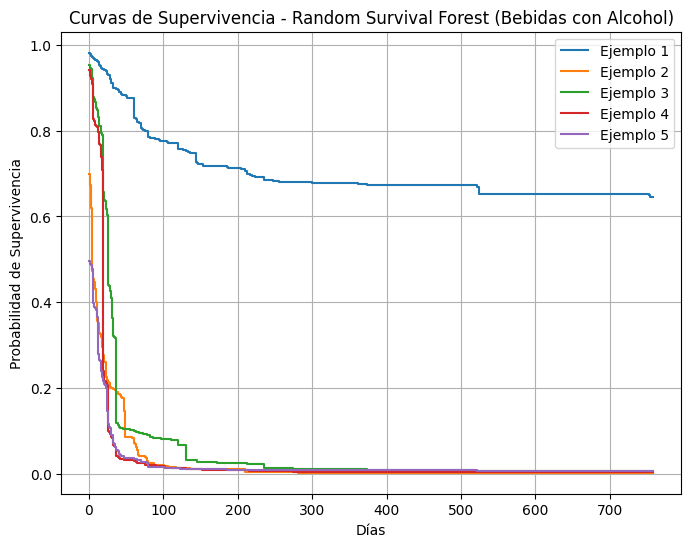

<Figure size 640x480 with 0 Axes>

In [53]:
## RANDOM SURVIVAL FOREST PARA BEBIDAS CON ALCOHOL ##

# Transformamos 'df_general_results' y 'df_train_test_results' al formato pd.DataFrame si es Styler
if hasattr(df_general_results, "data"):
    df_general_results = df_general_results.data.copy()
if hasattr(df_train_test_results, "data"):
    df_train_test_results = df_train_test_results.data.copy()
_ = None

# Escalamos los datos con preservación del índice
scaler = StandardScaler()
X_train_bebidas_con_alcohol_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_bebidas_con_alcohol), 
    index=pd.RangeIndex(len(X_train_bebidas_con_alcohol)), 
    columns=[f"Feature_{i}" for i in range(X_train_bebidas_con_alcohol.shape[1])]
)
X_test_bebidas_con_alcohol_scaled = pd.DataFrame(
    scaler.transform(X_test_bebidas_con_alcohol), 
    index=pd.RangeIndex(len(X_test_bebidas_con_alcohol)), 
    columns=[f"Feature_{i}" for i in range(X_test_bebidas_con_alcohol.shape[1])]
)

# Definimos los hiperparámetros del modelo
rsf_params_bebidas_con_alcohol = {
    "n_estimators": 900,
    "min_samples_split": 8,
    "min_samples_leaf": 18,
    "max_features": "log2",
    "max_depth": None,
    "random_state": 42,
    "n_jobs": -1
}

# Entrenamos el modelo directamente con los datos de entrenamiento
best_rsf_model_bebidas_con_alcohol = RandomSurvivalForest(**rsf_params_bebidas_con_alcohol)
best_rsf_model_bebidas_con_alcohol.fit(X_train_bebidas_con_alcohol_scaled, y_train_bebidas_con_alcohol)

# Evaluamos el modelo con Concordance Index
c_index_test_bebidas_con_alcohol = concordance_index_censored(
    y_test_bebidas_con_alcohol["Evento"],  
    y_test_bebidas_con_alcohol["Duración"], 
    best_rsf_model_bebidas_con_alcohol.predict(X_test_bebidas_con_alcohol_scaled)
)[0]

c_index_train_bebidas_con_alcohol = concordance_index_censored(
    y_train_bebidas_con_alcohol["Evento"],  
    y_train_bebidas_con_alcohol["Duración"], 
    best_rsf_model_bebidas_con_alcohol.predict(X_train_bebidas_con_alcohol_scaled)
)[0]

print(f"Hiperparámetros del Modelo RSF para Bebidas con Alcohol: {rsf_params_bebidas_con_alcohol}\n")
print(f"Concordance Index (C-index) en Train para Bebidas con Alcohol: {c_index_train_bebidas_con_alcohol:.3f}")
print(f"Concordance Index (C-index) en Test para Bebidas con Alcohol: {c_index_test_bebidas_con_alcohol:.3f}\n")

# Definimos la grilla de tiempo para las predicciones
fecha_inicio = datetime(2021, 1, 1)  
fecha_fin = datetime(2024, 6, 30)  
diferencia_dias = (fecha_fin - fecha_inicio).days

# Ajustamos el rango de tiempo permitido
survival_curves_train_raw = best_cox_model_bebidas_con_alcohol.predict_survival_function(X_train_bebidas_con_alcohol_scaled)

# Obtenemos el tiempo máximo permitido
max_time = min([func.x.max() for func in survival_curves_train_raw])

# Restringimos time_grid dentro del rango permitido
time_grid = np.arange(1, min(diferencia_dias, max_time) + 1, 1)

# Generamos las curvas de supervivencia en Train
survival_curves_train_raw = best_rsf_model_bebidas_con_alcohol.predict_survival_function(X_train_bebidas_con_alcohol_scaled)
survival_curves_train = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_train_raw]),
    index=time_grid,
    columns=X_train_bebidas_con_alcohol_scaled.index
)

# Evaluamos con SurvivalEVAL en Train
eval_RSF_train = LifelinesEvaluator(
    survival_curves_train, 
    y_train_bebidas_con_alcohol["Duración"], 
    y_train_bebidas_con_alcohol["Evento"],
    y_train_bebidas_con_alcohol["Duración"], 
    y_train_bebidas_con_alcohol["Evento"]
)
mae_RSF_uncensored_train_bebidas_con_alcohol = eval_RSF_train.mae(method="Uncensored")

# Generamos las curvas de supervivencia en Test
survival_curves_raw = best_rsf_model_bebidas_con_alcohol.predict_survival_function(X_test_bebidas_con_alcohol_scaled)
survival_curves = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_raw]),  
    index=time_grid,  
    columns=X_test_bebidas_con_alcohol_scaled.index
)

# Evaluamos con SurvivalEVAL en Test
eval_RSF = LifelinesEvaluator(
    survival_curves, 
    y_test_bebidas_con_alcohol["Duración"], 
    y_test_bebidas_con_alcohol["Evento"],
    y_train_bebidas_con_alcohol["Duración"], 
    y_train_bebidas_con_alcohol["Evento"]
)
mae_RSF_uncensored_test_bebidas_con_alcohol = eval_RSF.mae(method="Uncensored")

# Imprimimos valores obtenidos
print(f"MAE RSF (con datos no censurados) en Train para Bebidas con Alcohol: {mae_RSF_uncensored_train_bebidas_con_alcohol:.3f}")
print(f"MAE RSF (con datos no censurados) en Test para Bebidas con Alcohol: {mae_RSF_uncensored_test_bebidas_con_alcohol:.3f}\n")

# Guardamos el modelo y sus métricas en un diccionario 
model_metadata_rsf_bebidas_con_alcohol = {
    "modelo": best_rsf_model_bebidas_con_alcohol,
    "c_index_train": c_index_train_bebidas_con_alcohol,
    "c_index_test": c_index_test_bebidas_con_alcohol,
    "mae_uncensored_train": mae_RSF_uncensored_train_bebidas_con_alcohol,
    "mae_uncensored_test": mae_RSF_uncensored_test_bebidas_con_alcohol,
    "hiperparametros": rsf_params_bebidas_con_alcohol
}

# Guardamos el modelo entrenado en formato diccionario con los resultados de los estadísticos
output_dir = "./BEBIDAS CON ALCOHOL"
os.makedirs(output_dir, exist_ok=True)
model_filename = os.path.join(output_dir, "Random_Survival_Forest_Bebidas_Con_Alcohol.pkl")
joblib.dump(model_metadata_rsf_bebidas_con_alcohol, model_filename, compress=3)

# Guardamos los resultados en 'df_general_results'
if not ((df_general_results["Modelo"] == "Random Survival Forest") & (df_general_results["Rubro"] == "Bebidas con Alcohol")).any():
    df_general_results = pd.concat([df_general_results, pd.DataFrame({
        "Rubro": ["Bebidas con Alcohol"],
        "Modelo": ["Random Survival Forest"],
        "C-Index": [c_index_test_bebidas_con_alcohol],
        "MAE": [mae_RSF_uncensored_test_bebidas_con_alcohol], 
        "Características": [str(rsf_params_bebidas_con_alcohol)]
    })], ignore_index=True)

# Guardamos los resultados en 'df_train_test_results' 
if not ((df_train_test_results["Modelo"] == "Random Survival Forest") & (df_train_test_results["Rubro"] == "Bebidas con Alcohol")).any():
    df_train_test_results = pd.concat([df_train_test_results, pd.DataFrame({
        "Rubro": ["Bebidas con Alcohol"],
        "Modelo": ["Random Survival Forest"],
        "Test_C-Index": [c_index_test_bebidas_con_alcohol], 
        "Train_C-Index": [c_index_train_bebidas_con_alcohol],
        "Test_MAE": [mae_RSF_uncensored_test_bebidas_con_alcohol], 
        "Train_MAE": [mae_RSF_uncensored_train_bebidas_con_alcohol] 
    })], ignore_index=True)

# Visualización de las curvas de supervivencia
plt.figure(figsize=(8, 6))
for i, surv_func in enumerate(best_rsf_model_bebidas_con_alcohol.predict_survival_function(X_test_sample)):
    plt.step(surv_func.x, surv_func.y, where="post", label=f"Ejemplo {i+1}")

plt.xlabel("Días")
plt.ylabel("Probabilidad de Supervivencia")
plt.title("Curvas de Supervivencia - Random Survival Forest (Bebidas con Alcohol)")
plt.legend()
plt.grid()
plt.show()

# Guardamos la imagen de las curvas de supervivencia proyectadas
image_filename_bebidas_con_alcohol = os.path.join(output_dir, "Random_Survival_Forest_Curva_de_Supervivencia_Bebidas_con_Alcohol.png")
plt.savefig(image_filename_bebidas_con_alcohol, dpi=300, bbox_inches="tight")

In [55]:
## ANÁLISIS NUMÉRICO DE OVERFITTING PARA SURVIVAL RANDOM FOREST (BEBIDAS CON ALCOHOL) ##

# Evaluamos el modelo en el conjunto completo de entrenamiento y prueba
c_index_train_bebidas_con_alcohol = concordance_index_censored(
    y_train_bebidas_con_alcohol["Evento"],  
    y_train_bebidas_con_alcohol["Duración"], 
    best_rsf_model_bebidas_con_alcohol.predict(X_train_bebidas_con_alcohol)
)[0]

c_index_test_bebidas_con_alcohol = concordance_index_censored(
    y_test_bebidas_con_alcohol["Evento"],  
    y_test_bebidas_con_alcohol["Duración"], 
    best_rsf_model_bebidas_con_alcohol.predict(X_test_bebidas_con_alcohol)
)[0]

# Imprimimos resultados
print(f"\nConcordance Index (C-index) para Bebidas con Alcohol en Train: {c_index_train_bebidas_con_alcohol:.3f}")
print(f"Concordance Index (C-index) para Bebidas con Alcohol en Test: {c_index_test_bebidas_con_alcohol:.3f}")

# Comparación de resultados
if c_index_train_bebidas_con_alcohol - c_index_test_bebidas_con_alcohol > 0.05:
    print("Posible Overfitting: El modelo tiene un mejor desempeño en entrenamiento que en prueba para Bebidas con Alcohol.")
else:
    print("No hay signos evidentes de Overfitting en Bebidas con Alcohol.")


Concordance Index (C-index) para Bebidas con Alcohol en Train: 0.585
Concordance Index (C-index) para Bebidas con Alcohol en Test: 0.583
No hay signos evidentes de Overfitting en Bebidas con Alcohol.


#### **2.2.3**   **<ins>Bebidas sin Alcohol</ins>**

In [57]:
### DEFINICIÓN DEL CONJUNTO PARA BEBIDAS SIN ALCOHOL ###

# Filtramos solo los registros del rubro "Bebidas sin Alcohol"
df_bebidas_sin_alcohol = df_price_spells[df_price_spells["Rubro"] == "Bebidas sin Alcohol"].copy()

# Convertimos el DataFrame al formato de supervivencia
y_bebidas_sin_alcohol = Surv.from_dataframe("Evento", time_variable, df_bebidas_sin_alcohol)
encoder_bebidas_sin_alcohol = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Aplicamos el OneHotEncoder a las variables categóricas
X_cat_bebidas_sin_alcohol = encoder_bebidas_sin_alcohol.fit_transform(df_bebidas_sin_alcohol[categorical_columns])

# Extraemos las variables numéricas
X_num_bebidas_sin_alcohol = df_bebidas_sin_alcohol[numeric_columns].values

# Concatenamos ambas partes para formar la matriz final de predictores
X_final_bebidas_sin_alcohol = np.concatenate([X_cat_bebidas_sin_alcohol, X_num_bebidas_sin_alcohol], axis=1)

# Dividimos en 70% Train y 30% Test directamente
X_train_bebidas_sin_alcohol, X_test_bebidas_sin_alcohol, y_train_bebidas_sin_alcohol, y_test_bebidas_sin_alcohol = train_test_split(
    X_final_bebidas_sin_alcohol, y_bebidas_sin_alcohol, test_size=0.3, random_state=42
)

# Verificamos los tamaños de cada conjunto
total_registros_bebidas_sin_alcohol = X_final_bebidas_sin_alcohol.shape[0]
print(f"Tamaño del conjunto de entrenamiento: {X_train_bebidas_sin_alcohol.shape[0]} ({(X_train_bebidas_sin_alcohol.shape[0] / total_registros_bebidas_sin_alcohol) * 100:.2f}%)")
print(f"Tamaño del conjunto de prueba: {X_test_bebidas_sin_alcohol.shape[0]} ({(X_test_bebidas_sin_alcohol.shape[0] / total_registros_bebidas_sin_alcohol) * 100:.2f}%)")

Tamaño del conjunto de entrenamiento: 20000 (70.00%)
Tamaño del conjunto de prueba: 8572 (30.00%)


##### **2.2.3.1** **<ins>Cox</ins>** ***(Cox Proportional Hazards Model)***

Mejores hiperparámetros para Bebidas sin Alcohol: {'alpha_min_ratio': 0.001, 'l1_ratio': 0.5}

Concordance Index (C-index) para Bebidas sin Alcohol en Train: 0.676
Concordance Index (C-index) para Bebidas sin Alcohol en Test: 0.672

MAE COX (con datos no censurados) para Bebidas sin Alcohol en Train: 60.889
MAE COX (con datos no censurados) para Bebidas sin Alcohol en Test: 62.165



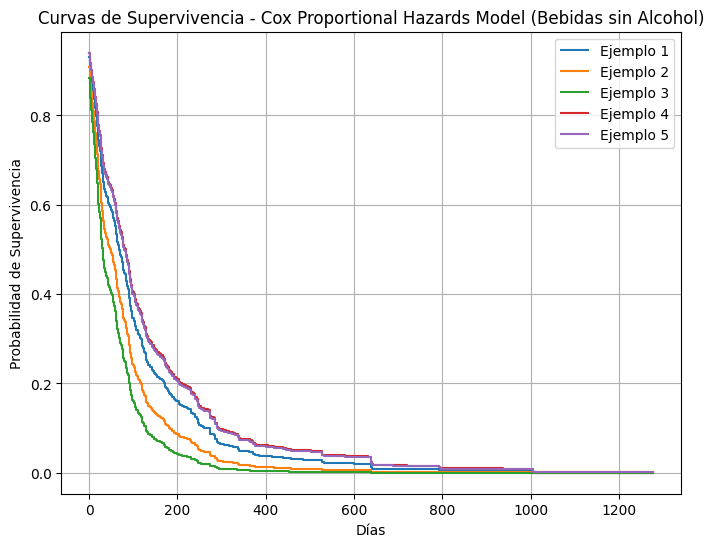

<Figure size 640x480 with 0 Axes>

In [58]:
## COX (Cox Proportional Hazards Model) PARA BEBIDAS SIN ALCOHOL ##

# Transformamos 'df_general_results' y 'df_train_test_results' al formato pd.DataFrame si es Styler
if hasattr(df_general_results, "data"):
    df_general_results = df_general_results.data.copy()
if hasattr(df_train_test_results, "data"):
    df_train_test_results = df_train_test_results.data.copy()
_ = None

# Escalamos los datos con preservación del índice
scaler = StandardScaler()
X_train_bebidas_sin_alcohol_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_bebidas_sin_alcohol), 
    index=pd.RangeIndex(len(X_train_bebidas_sin_alcohol)), 
    columns=[f"Feature_{i}" for i in range(X_train_bebidas_sin_alcohol.shape[1])]
)
X_test_bebidas_sin_alcohol_scaled = pd.DataFrame(
    scaler.transform(X_test_bebidas_sin_alcohol), 
    index=pd.RangeIndex(len(X_test_bebidas_sin_alcohol)), 
    columns=[f"Feature_{i}" for i in range(X_test_bebidas_sin_alcohol.shape[1])]
)

# Hiperparametrización COX
param_grid = {
    "l1_ratio": [0.1, 0.5, 0.9],  
    "alpha_min_ratio": [0.001, 0.01, 0.1]  
}

cox_grid = GridSearchCV(
    CoxnetSurvivalAnalysis(fit_baseline_model=True),
    param_grid,
    scoring=lambda est, X, y: concordance_index_censored(y["Evento"], y["Duración"], est.predict(X))[0],
    cv=5,
    n_jobs=-1
)

# Entrenamos el modelo con búsqueda de hiperparámetros
cox_grid.fit(X_train_bebidas_sin_alcohol_scaled, y_train_bebidas_sin_alcohol)

# Seleccionamos el mejor modelo
best_cox_model_bebidas_sin_alcohol = cox_grid.best_estimator_

# Evaluamos el mejor modelo
c_index_test_bebidas_sin_alcohol = concordance_index_censored(
    y_test_bebidas_sin_alcohol["Evento"],  
    y_test_bebidas_sin_alcohol["Duración"], 
    best_cox_model_bebidas_sin_alcohol.predict(X_test_bebidas_sin_alcohol_scaled)
)[0]

c_index_train_bebidas_sin_alcohol = concordance_index_censored(
    y_train_bebidas_sin_alcohol["Evento"],  
    y_train_bebidas_sin_alcohol["Duración"], 
    best_cox_model_bebidas_sin_alcohol.predict(X_train_bebidas_sin_alcohol_scaled)
)[0]

print(f"Mejores hiperparámetros para Bebidas sin Alcohol: {cox_grid.best_params_}\n")
print(f"Concordance Index (C-index) para Bebidas sin Alcohol en Train: {c_index_train_bebidas_sin_alcohol:.3f}")
print(f"Concordance Index (C-index) para Bebidas sin Alcohol en Test: {c_index_test_bebidas_sin_alcohol:.3f}\n")

# Definimos la grilla de tiempo para las predicciones
fecha_inicio = datetime(2021, 1, 1)  
fecha_fin = datetime(2024, 6, 30)  
diferencia_dias = (fecha_fin - fecha_inicio).days
time_grid = np.arange(1, diferencia_dias + 1, 1)  

# Generamos las curvas de supervivencia en Train
survival_curves_train_raw = best_cox_model_bebidas_sin_alcohol.predict_survival_function(X_train_bebidas_sin_alcohol_scaled)
survival_curves_train = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_train_raw]),
    index=time_grid,
    columns=X_train_bebidas_sin_alcohol_scaled.index
)

# Evaluamos con SurvivalEVAL en Train
eval_COX_train = LifelinesEvaluator(
    survival_curves_train, 
    y_train_bebidas_sin_alcohol["Duración"], 
    y_train_bebidas_sin_alcohol["Evento"],
    y_train_bebidas_sin_alcohol["Duración"], 
    y_train_bebidas_sin_alcohol["Evento"]
)
mae_COX_uncensored_train_bebidas_sin_alcohol = eval_COX_train.mae(method="Uncensored")

# Generamos las curvas de supervivencia en Test
survival_curves_raw = best_cox_model_bebidas_sin_alcohol.predict_survival_function(X_test_bebidas_sin_alcohol_scaled)
survival_curves = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_raw]),  
    index=time_grid,  
    columns=X_test_bebidas_sin_alcohol_scaled.index
)

# Evaluamos con SurvivalEVAL en Test
eval_COX = LifelinesEvaluator(
    survival_curves, 
    y_test_bebidas_sin_alcohol["Duración"], 
    y_test_bebidas_sin_alcohol["Evento"],
    y_train_bebidas_sin_alcohol["Duración"], 
    y_train_bebidas_sin_alcohol["Evento"]
)
mae_COX_uncensored_test_bebidas_sin_alcohol = eval_COX.mae(method="Uncensored")

# Imprimimos valores obtenidos
print(f"MAE COX (con datos no censurados) para Bebidas sin Alcohol en Train: {mae_COX_uncensored_train_bebidas_sin_alcohol:.3f}")
print(f"MAE COX (con datos no censurados) para Bebidas sin Alcohol en Test: {mae_COX_uncensored_test_bebidas_sin_alcohol:.3f}\n")

# Guardamos el modelo y sus métricas en un diccionario 
model_metadata_bebidas_sin_alcohol = {
    "modelo": best_cox_model_bebidas_sin_alcohol,
    "c_index_train": c_index_train_bebidas_sin_alcohol,
    "c_index_test": c_index_test_bebidas_sin_alcohol,
    "mae_uncensored_train": mae_COX_uncensored_train_bebidas_sin_alcohol,
    "mae_uncensored_test": mae_COX_uncensored_test_bebidas_sin_alcohol,
    "hiperparametros": cox_grid.best_params_ 
}

# Guardamos el modelo entrenado en formato diccionario con los resultados de los estadísticos
output_dir = "./BEBIDAS SIN ALCOHOL"
os.makedirs(output_dir, exist_ok=True)
model_filename = os.path.join(output_dir, "Cox_Proportional_Hazards_Model_Bebidas_Sin_Alcohol.pkl")
joblib.dump(model_metadata_bebidas_sin_alcohol, model_filename, compress=3)

# Guardamos los resultados en 'df_general_results'
if not ((df_general_results["Modelo"] == "Cox Proportional Hazards Model") & (df_general_results["Rubro"] == "Bebidas sin Alcohol")).any():
    df_general_results = pd.concat([df_general_results, pd.DataFrame({
        "Rubro": ["Bebidas sin Alcohol"],
        "Modelo": ["Cox Proportional Hazards Model"],
        "C-Index": [c_index_test_bebidas_sin_alcohol],
        "MAE": [mae_COX_uncensored_test_bebidas_sin_alcohol], 
        "Características": [str(cox_grid.best_params_)]
    })], ignore_index=True)

# Guardamos los resultados en 'df_train_test_results'
if not ((df_train_test_results["Modelo"] == "Cox Proportional Hazards Model") & (df_train_test_results["Rubro"] == "Bebidas sin Alcohol")).any():
    df_train_test_results = pd.concat([df_train_test_results, pd.DataFrame({
        "Rubro": ["Bebidas sin Alcohol"],
        "Modelo": ["Cox Proportional Hazards Model"],
        "Test_C-Index": [c_index_test_bebidas_sin_alcohol], 
        "Train_C-Index": [c_index_train_bebidas_sin_alcohol],
        "Test_MAE": [mae_COX_uncensored_test_bebidas_sin_alcohol], 
        "Train_MAE": [mae_COX_uncensored_train_bebidas_sin_alcohol] 
    })], ignore_index=True)

# Proyección de la curva de supervivencia en ejemplos de test
num_samples = 5
sample_indices = np.random.choice(X_test_bebidas_sin_alcohol_scaled.shape[0], num_samples, replace=False)
X_test_sample = X_test_bebidas_sin_alcohol_scaled.iloc[sample_indices]

# Visualización de las curvas de supervivencia
plt.figure(figsize=(8, 6))
for i, surv_func in enumerate(best_cox_model_bebidas_sin_alcohol.predict_survival_function(X_test_sample)):
    plt.step(surv_func.x, surv_func.y, where="post", label=f"Ejemplo {i+1}")

plt.xlabel("Días")
plt.ylabel("Probabilidad de Supervivencia")
plt.title("Curvas de Supervivencia - Cox Proportional Hazards Model (Bebidas sin Alcohol)")
plt.legend()
plt.grid()
plt.show()

# Guardamos la imagen de las curvas de supervivencia
image_filename = os.path.join(output_dir, "Cox_Proportional_Hazards_Model_Curva_de_Supervivencia_Bebidas_sin_Alcohol.png")
plt.savefig(image_filename, dpi=300, bbox_inches="tight")

In [60]:
## ANÁLISIS NUMÉRICO DE OVERFITTING PARA COX (Cox Proportional Hazards Model) (BEBIDAS SIN ALCOHOL) ##

# Evaluamos el modelo en el conjunto completo de entrenamiento y prueba
c_index_train_bebidas_sin_alcohol = concordance_index_censored(
    y_train_bebidas_sin_alcohol["Evento"],  
    y_train_bebidas_sin_alcohol["Duración"], 
    best_cox_model_bebidas_sin_alcohol.predict(X_train_bebidas_sin_alcohol_scaled)
)[0]

c_index_test_bebidas_sin_alcohol = concordance_index_censored(
    y_test_bebidas_sin_alcohol["Evento"],  
    y_test_bebidas_sin_alcohol["Duración"], 
    best_cox_model_bebidas_sin_alcohol.predict(X_test_bebidas_sin_alcohol_scaled)
)[0]

# Imprimimos resultados
print(f"\nConcordance Index (C-index) para Bebidas sin Alcohol en Train: {c_index_train_bebidas_sin_alcohol:.3f}")
print(f"Concordance Index (C-index) para Bebidas sin Alcohol en Test: {c_index_test_bebidas_sin_alcohol:.3f}")

# Comparación de resultados
if c_index_train_bebidas_sin_alcohol - c_index_test_bebidas_sin_alcohol > 0.05:
    print("Posible Overfitting: El modelo tiene un mejor desempeño en entrenamiento que en prueba para Bebidas sin Alcohol.")
else:
    print("No hay signos evidentes de Overfitting en Bebidas sin Alcohol.")


Concordance Index (C-index) para Bebidas sin Alcohol en Train: 0.676
Concordance Index (C-index) para Bebidas sin Alcohol en Test: 0.672
No hay signos evidentes de Overfitting en Bebidas sin Alcohol.


##### **2.2.3.2**   **<ins>Random Survival Forest</ins>**

Hiperparámetros del Modelo RSF para Bebidas sin Alcohol: {'n_estimators': 700, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': 'log2', 'max_depth': None, 'random_state': 42, 'n_jobs': -1}

Concordance Index (C-index) en Train para Bebidas sin Alcohol: 0.735
Concordance Index (C-index) en Test para Bebidas sin Alcohol: 0.735

MAE RSF (con datos no censurados) en Train para Bebidas sin Alcohol: 31.054
MAE RSF (con datos no censurados) en Test para Bebidas sin Alcohol: 32.693



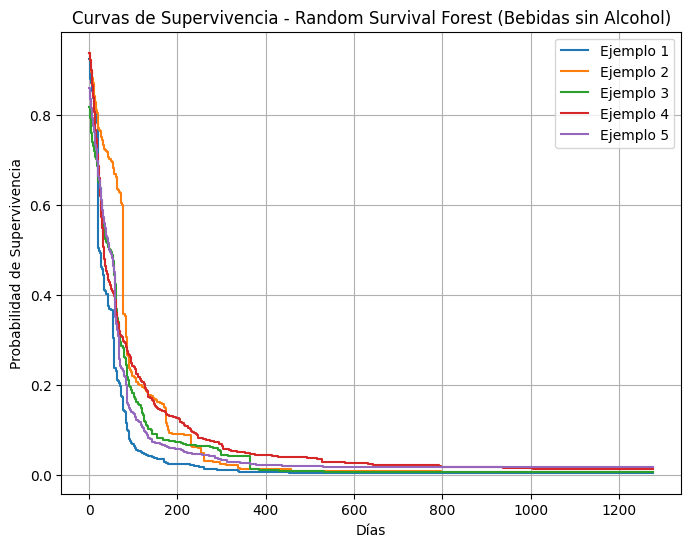

<Figure size 640x480 with 0 Axes>

In [61]:
## RANDOM SURVIVAL FOREST PARA BEBIDAS SIN ALCOHOL ##

# Transformamos 'df_general_results' y 'df_train_test_results' al formato pd.DataFrame si es Styler
if hasattr(df_general_results, "data"):
    df_general_results = df_general_results.data.copy()
if hasattr(df_train_test_results, "data"):
    df_train_test_results = df_train_test_results.data.copy()
_ = None

# Escalamos los datos con preservación del índice
scaler = StandardScaler()
X_train_bebidas_sin_alcohol_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_bebidas_sin_alcohol), 
    index=pd.RangeIndex(len(X_train_bebidas_sin_alcohol)), 
    columns=[f"Feature_{i}" for i in range(X_train_bebidas_sin_alcohol.shape[1])]
)
X_test_bebidas_sin_alcohol_scaled = pd.DataFrame(
    scaler.transform(X_test_bebidas_sin_alcohol), 
    index=pd.RangeIndex(len(X_test_bebidas_sin_alcohol)), 
    columns=[f"Feature_{i}" for i in range(X_test_bebidas_sin_alcohol.shape[1])]
)

# Definimos los hiperparámetros del modelo
rsf_params_bebidas_sin_alcohol = {
    "n_estimators": 700,
    "min_samples_split": 10,
    "min_samples_leaf": 20,
    "max_features": "log2",
    "max_depth": None,
    "random_state": 42,
    "n_jobs": -1
}

# Entrenamos el modelo directamente con los datos de entrenamiento
best_rsf_model_bebidas_sin_alcohol = RandomSurvivalForest(**rsf_params_bebidas_sin_alcohol)
best_rsf_model_bebidas_sin_alcohol.fit(X_train_bebidas_sin_alcohol_scaled, y_train_bebidas_sin_alcohol)

# Evaluamos el modelo con Concordance Index
c_index_test_bebidas_sin_alcohol = concordance_index_censored(
    y_test_bebidas_sin_alcohol["Evento"], y_test_bebidas_sin_alcohol["Duración"], 
    best_rsf_model_bebidas_sin_alcohol.predict(X_test_bebidas_sin_alcohol_scaled)
)[0]
c_index_train_bebidas_sin_alcohol = concordance_index_censored(
    y_train_bebidas_sin_alcohol["Evento"], y_train_bebidas_sin_alcohol["Duración"], 
    best_rsf_model_bebidas_sin_alcohol.predict(X_train_bebidas_sin_alcohol_scaled)
)[0]

print(f"Hiperparámetros del Modelo RSF para Bebidas sin Alcohol: {rsf_params_bebidas_sin_alcohol}\n")
print(f"Concordance Index (C-index) en Train para Bebidas sin Alcohol: {c_index_train_bebidas_sin_alcohol:.3f}")
print(f"Concordance Index (C-index) en Test para Bebidas sin Alcohol: {c_index_test_bebidas_sin_alcohol:.3f}\n")

# Definimos la grilla de tiempo para las predicciones
fecha_inicio = datetime(2021, 1, 1)
fecha_fin = datetime(2024, 6, 30)
diferencia_dias = (fecha_fin - fecha_inicio).days
time_grid = np.arange(1, diferencia_dias + 1, 1)

# Generamos las curvas de supervivencia en Train
survival_curves_train_raw = best_rsf_model_bebidas_sin_alcohol.predict_survival_function(X_train_bebidas_sin_alcohol_scaled)
survival_curves_train = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_train_raw]),
    index=time_grid,
    columns=X_train_bebidas_sin_alcohol_scaled.index
)

# Evaluamos con SurvivalEVAL en Train
eval_RSF_train = LifelinesEvaluator(
    survival_curves_train, y_train_bebidas_sin_alcohol["Duración"], y_train_bebidas_sin_alcohol["Evento"],
    y_train_bebidas_sin_alcohol["Duración"], y_train_bebidas_sin_alcohol["Evento"]
)
mae_RSF_uncensored_train_bebidas_sin_alcohol = eval_RSF_train.mae(method="Uncensored")

# Generamos las curvas de supervivencia en Test
survival_curves_raw = best_rsf_model_bebidas_sin_alcohol.predict_survival_function(X_test_bebidas_sin_alcohol_scaled)
survival_curves = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_raw]),  
    index=time_grid,  
    columns=X_test_bebidas_sin_alcohol_scaled.index
)

# Evaluamos con SurvivalEVAL en Test
eval_RSF = LifelinesEvaluator(
    survival_curves, y_test_bebidas_sin_alcohol["Duración"], y_test_bebidas_sin_alcohol["Evento"],
    y_train_bebidas_sin_alcohol["Duración"], y_train_bebidas_sin_alcohol["Evento"]
)
mae_RSF_uncensored_test_bebidas_sin_alcohol = eval_RSF.mae(method="Uncensored")

# Imprimimos valores obtenidos
print(f"MAE RSF (con datos no censurados) en Train para Bebidas sin Alcohol: {mae_RSF_uncensored_train_bebidas_sin_alcohol:.3f}")
print(f"MAE RSF (con datos no censurados) en Test para Bebidas sin Alcohol: {mae_RSF_uncensored_test_bebidas_sin_alcohol:.3f}\n")

# Guardamos el modelo y sus métricas en un diccionario 
model_metadata_rsf_bebidas_sin_alcohol = {
    "modelo": best_rsf_model_bebidas_sin_alcohol,
    "c_index_train": c_index_train_bebidas_sin_alcohol,
    "c_index_test": c_index_test_bebidas_sin_alcohol,
    "mae_uncensored_train": mae_RSF_uncensored_train_bebidas_sin_alcohol,
    "mae_uncensored_test": mae_RSF_uncensored_test_bebidas_sin_alcohol,
    "hiperparametros": rsf_params_bebidas_sin_alcohol
}

# Guardamos el modelo entrenado en formato diccionario con los resultados de los estadísticos
output_dir = "./BEBIDAS SIN ALCOHOL"
os.makedirs(output_dir, exist_ok=True)
model_filename = os.path.join(output_dir, "Random_Survival_Forest_Bebidas_Sin_Alcohol.pkl")
joblib.dump(model_metadata_rsf_bebidas_sin_alcohol, model_filename, compress=3)

# Guardamos los resultados en 'df_general_results'
if not ((df_general_results["Modelo"] == "Random Survival Forest") & (df_general_results["Rubro"] == "Bebidas sin Alcohol")).any():
    df_general_results = pd.concat([df_general_results, pd.DataFrame({
        "Rubro": ["Bebidas sin Alcohol"],
        "Modelo": ["Random Survival Forest"],
        "C-Index": [c_index_test_bebidas_sin_alcohol],
        "MAE": [mae_RSF_uncensored_test_bebidas_sin_alcohol], 
        "Características": [str(rsf_params_bebidas_sin_alcohol)]
    })], ignore_index=True)

# Guardamos los resultados en 'df_train_test_results' 
if not ((df_train_test_results["Modelo"] == "Random Survival Forest") & (df_train_test_results["Rubro"] == "Bebidas sin Alcohol")).any():
    df_train_test_results = pd.concat([df_train_test_results, pd.DataFrame({
        "Rubro": ["Bebidas sin Alcohol"],
        "Modelo": ["Random Survival Forest"],
        "Test_C-Index": [c_index_test_bebidas_sin_alcohol], 
        "Train_C-Index": [c_index_train_bebidas_sin_alcohol],
        "Test_MAE": [mae_RSF_uncensored_test_bebidas_sin_alcohol], 
        "Train_MAE": [mae_RSF_uncensored_train_bebidas_sin_alcohol] 
    })], ignore_index=True)

# Proyección de la curva de supervivencia en ejemplos de test
num_samples = 5
sample_indices = np.random.choice(X_test_bebidas_sin_alcohol_scaled.shape[0], num_samples, replace=False)
X_test_sample = X_test_bebidas_sin_alcohol_scaled.iloc[sample_indices]

# Visualización de las curvas de supervivencia
plt.figure(figsize=(8, 6))
for i, surv_func in enumerate(best_rsf_model_bebidas_sin_alcohol.predict_survival_function(X_test_sample)):
    plt.step(surv_func.x, surv_func.y, where="post", label=f"Ejemplo {i+1}")

plt.xlabel("Días")
plt.ylabel("Probabilidad de Supervivencia")
plt.title("Curvas de Supervivencia - Random Survival Forest (Bebidas sin Alcohol)")
plt.legend()
plt.grid()
plt.show()

# Guardamos la imagen de las curvas de supervivencia proyectadas
image_filename_bebidas_sin_alcohol = os.path.join(output_dir, "Random_Survival_Forest_Curva_de_Supervivencia_Bebidas_sin_Alcohol.png")
plt.savefig(image_filename_bebidas_sin_alcohol, dpi=300, bbox_inches="tight")

In [53]:
'''
## CARGA MODELO SURVIVAL RANDOM FOREST (BEBIDAS SIN ALCOHOL) ##

# Ruta del modelo entrenado
model_path_rsf_bebidas_sin_alcohol = "./BEBIDAS SIN ALCOHOL/Random_Survival_Forest_Bebidas_Sin_Alcohol.pkl"
model_metadata_rsf_bebidas_sin_alcohol = joblib.load(model_path_rsf_bebidas_sin_alcohol)

# Extraemos el modelo y sus métricas del diccionario
best_rsf_model_bebidas_sin_alcohol = model_metadata_rsf_bebidas_sin_alcohol.get("modelo", None)  
c_index_train_bebidas_sin_alcohol = model_metadata_rsf_bebidas_sin_alcohol.get("c_index_train", None)
c_index_test_bebidas_sin_alcohol = model_metadata_rsf_bebidas_sin_alcohol.get("c_index_test", None)
mae_RSF_uncensored_train_bebidas_sin_alcohol = model_metadata_rsf_bebidas_sin_alcohol.get("mae_uncensored_train", None)
mae_RSF_uncensored_test_bebidas_sin_alcohol = model_metadata_rsf_bebidas_sin_alcohol.get("mae_uncensored_test", None)
hiperparametros_bebidas_sin_alcohol = model_metadata_rsf_bebidas_sin_alcohol.get("hiperparametros", {})

# Mostramos los hiperparámetros almacenados en una sola línea
print(f"Hiperparámetros del Modelo RSF para Bebidas sin Alcohol: {hiperparametros_bebidas_sin_alcohol}")

# Imprimimos métricas del modelo si están disponibles
print("\nMétricas del Modelo RSF para Bebidas sin Alcohol:")
print(f"Concordance Index (C-index) en Train: {c_index_train_bebidas_sin_alcohol:.3f}")
print(f"Concordance Index (C-index) en Test: {c_index_test_bebidas_sin_alcohol:.3f}\n")
print(f"MAE RSF (Uncensored) en Train: {mae_RSF_uncensored_train_bebidas_sin_alcohol:.3f}")
print(f"MAE RSF (Uncensored) en Test: {mae_RSF_uncensored_test_bebidas_sin_alcohol:.3f}")

# Guardamos los valores en 'df_general_results' (solo si no están guardados)
if not ((df_general_results["Modelo"] == "Random Survival Forest") & 
        (df_general_results["Rubro"] == "Bebidas sin Alcohol")).any():
    df_general_results = pd.concat([df_general_results, pd.DataFrame({
        "Rubro": ["Bebidas sin Alcohol"],
        "Modelo": ["Random Survival Forest"],
        "C-Index": [c_index_test_bebidas_sin_alcohol] if c_index_test_bebidas_sin_alcohol is not None else [None],
        "MAE": [mae_RSF_uncensored_test_bebidas_sin_alcohol] if mae_RSF_uncensored_test_bebidas_sin_alcohol is not None else [None], 
    })], ignore_index=True)

# Guardamos los valores en 'df_train_test_results' (solo si no están guardados)
if not ((df_train_test_results["Modelo"] == "Random Survival Forest") & 
        (df_train_test_results["Rubro"] == "Bebidas sin Alcohol")).any():
    df_train_test_results = pd.concat([df_train_test_results, pd.DataFrame({
        "Rubro": ["Bebidas sin Alcohol"],
        "Modelo": ["Random Survival Forest"],
        "Test_C-Index": [c_index_test_bebidas_sin_alcohol] if c_index_test_bebidas_sin_alcohol is not None else [None], 
        "Train_C-Index": [c_index_train_bebidas_sin_alcohol] if c_index_train_bebidas_sin_alcohol is not None else [None],
        "Test_MAE": [mae_RSF_uncensored_test_bebidas_sin_alcohol] if mae_RSF_uncensored_test_bebidas_sin_alcohol is not None else [None], 
        "Train_MAE": [mae_RSF_uncensored_train_bebidas_sin_alcohol] if mae_RSF_uncensored_train_bebidas_sin_alcohol is not None else [None] 
    })], ignore_index=True)
'''

Hiperparámetros del Modelo RSF para Bebidas sin Alcohol: {'n_estimators': 700, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': 'log2', 'max_depth': None, 'random_state': 42, 'n_jobs': -1}

Métricas del Modelo RSF para Bebidas sin Alcohol:
Concordance Index (C-index) en Train: 0.735
Concordance Index (C-index) en Test: 0.735

MAE RSF (Uncensored) en Train: 31.054
MAE RSF (Uncensored) en Test: 32.693


In [63]:
## ANÁLISIS NUMÉRICO DE OVERFITTING PARA SURVIVAL RANDOM FOREST (BEBIDAS SIN ALCOHOL) ##

# Evaluamos el modelo en el conjunto completo de entrenamiento y prueba
c_index_train_bebidas_sin_alcohol = concordance_index_censored(
    y_train_bebidas_sin_alcohol["Evento"],  
    y_train_bebidas_sin_alcohol["Duración"], 
    best_rsf_model_bebidas_sin_alcohol.predict(X_train_bebidas_sin_alcohol)
)[0]

c_index_test_bebidas_sin_alcohol = concordance_index_censored(
    y_test_bebidas_sin_alcohol["Evento"],  
    y_test_bebidas_sin_alcohol["Duración"], 
    best_rsf_model_bebidas_sin_alcohol.predict(X_test_bebidas_sin_alcohol)
)[0]

# Imprimimos resultados
print(f"\nConcordance Index (C-index) para Bebidas sin Alcohol en Train: {c_index_train_bebidas_sin_alcohol:.3f}")
print(f"Concordance Index (C-index) para Bebidas sin Alcohol en Test: {c_index_test_bebidas_sin_alcohol:.3f}")

# Comparación de resultados
if c_index_train_bebidas_sin_alcohol - c_index_test_bebidas_sin_alcohol > 0.05:
    print("Posible Overfitting: El modelo tiene un mejor desempeño en entrenamiento que en prueba para Bebidas sin Alcohol.")
else:
    print("No hay signos evidentes de Overfitting en Bebidas sin Alcohol.")


Concordance Index (C-index) para Bebidas sin Alcohol en Train: 0.644
Concordance Index (C-index) para Bebidas sin Alcohol en Test: 0.648
No hay signos evidentes de Overfitting en Bebidas sin Alcohol.


#### **2.2.4**   **<ins>Cuidado Personal</ins>**

In [64]:
### DEFINICIÓN DEL CONJUNTO PARA CUIDADO PERSONAL ###

# Filtramos solo los registros del rubro "Cuidado Personal"
df_cuidado_personal = df_price_spells[df_price_spells["Rubro"] == "Cuidado Personal"].copy()

# Convertimos el DataFrame al formato de supervivencia
y_cuidado_personal = Surv.from_dataframe("Evento", time_variable, df_cuidado_personal)
encoder_cuidado_personal = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Aplicamos el OneHotEncoder a las variables categóricas
X_cat_cuidado_personal = encoder_cuidado_personal.fit_transform(df_cuidado_personal[categorical_columns])

# Extraemos las variables numéricas
X_num_cuidado_personal = df_cuidado_personal[numeric_columns].values

# Concatenamos ambas partes para formar la matriz final de predictores
X_final_cuidado_personal = np.concatenate([X_cat_cuidado_personal, X_num_cuidado_personal], axis=1)

# Dividimos en 70% Train y 30% Test directamente
X_train_cuidado_personal, X_test_cuidado_personal, y_train_cuidado_personal, y_test_cuidado_personal = train_test_split(
    X_final_cuidado_personal, y_cuidado_personal, test_size=0.3, random_state=42
)

# Verificamos los tamaños de cada conjunto
total_registros_cuidado_personal = X_final_cuidado_personal.shape[0]
print(f"Tamaño del conjunto de entrenamiento: {X_train_cuidado_personal.shape[0]} ({(X_train_cuidado_personal.shape[0] / total_registros_cuidado_personal) * 100:.2f}%)")
print(f"Tamaño del conjunto de prueba: {X_test_cuidado_personal.shape[0]} ({(X_test_cuidado_personal.shape[0] / total_registros_cuidado_personal) * 100:.2f}%)")

Tamaño del conjunto de entrenamiento: 64477 (70.00%)
Tamaño del conjunto de prueba: 27634 (30.00%)


##### **2.2.4.1**    **<ins>Cox</ins>** ***(Cox Proportional Hazards Model)***

Mejores hiperparámetros para Cuidado Personal: {'alpha_min_ratio': 0.001, 'l1_ratio': 0.1}

Concordance Index (C-index) para Cuidado Personal en Train: 0.663
Concordance Index (C-index) para Cuidado Personal en Test: 0.664

MAE COX (con datos no censurados) para Cuidado Personal en Train: 50.891
MAE COX (con datos no censurados) para Cuidado Personal en Test: 50.792



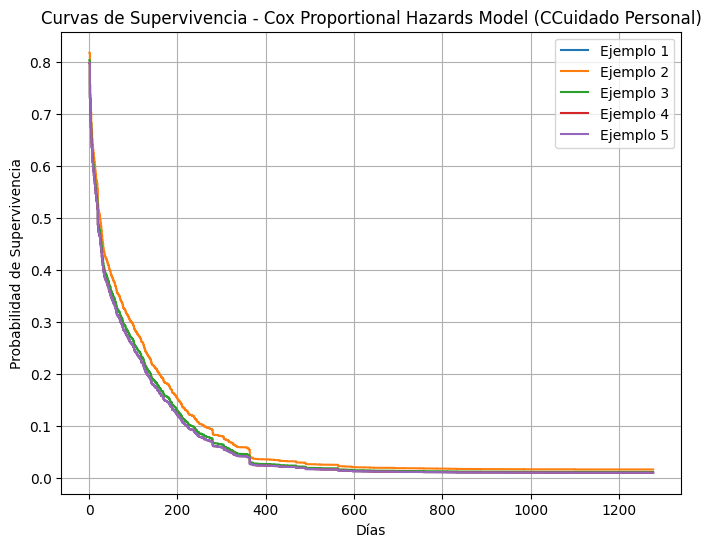

<Figure size 640x480 with 0 Axes>

In [65]:
## COX (Cox Proportional Hazards Model) PARA CUIDADO PERSONAL ##

# Transformamos 'df_general_results' y 'df_train_test_results' al formato pd.DataFrame si es Styler
if hasattr(df_general_results, "data"):
    df_general_results = df_general_results.data.copy()
if hasattr(df_train_test_results, "data"):
    df_train_test_results = df_train_test_results.data.copy()
_ = None

# Escalamos los datos con preservación del índice
scaler = StandardScaler()
X_train_cuidado_personal_scaled = pd.DataFrame(scaler.fit_transform(X_train_cuidado_personal), index=pd.RangeIndex(len(X_train_cuidado_personal)), columns=[f"Feature_{i}" for i in range(X_train_cuidado_personal.shape[1])])
X_test_cuidado_personal_scaled = pd.DataFrame(scaler.transform(X_test_cuidado_personal), index=pd.RangeIndex(len(X_test_cuidado_personal)), columns=[f"Feature_{i}" for i in range(X_test_cuidado_personal.shape[1])])

# Hiperparametrización COX
param_grid = {
    "l1_ratio": [0.1, 0.5, 0.9],  
    "alpha_min_ratio": [0.001, 0.01, 0.1]  
}

cox_grid = GridSearchCV(
    CoxnetSurvivalAnalysis(fit_baseline_model=True),
    param_grid,
    scoring=lambda est, X, y: concordance_index_censored(y["Evento"], y["Duración"], est.predict(X))[0],
    cv=5,
    n_jobs=-1
)

# Entrenamos el modelo con búsqueda de hiperparámetros
cox_grid.fit(X_train_cuidado_personal_scaled, y_train_cuidado_personal)

# Seleccionamos el mejor modelo
best_cox_model_cuidado_personal = cox_grid.best_estimator_

# Evaluamos el mejor modelo
c_index_test_cuidado_personal = concordance_index_censored(y_test_cuidado_personal["Evento"], y_test_cuidado_personal["Duración"], best_cox_model_cuidado_personal.predict(X_test_cuidado_personal_scaled))[0]
c_index_train_cuidado_personal = concordance_index_censored(y_train_cuidado_personal["Evento"], y_train_cuidado_personal["Duración"], best_cox_model_cuidado_personal.predict(X_train_cuidado_personal_scaled))[0]

print(f"Mejores hiperparámetros para Cuidado Personal: {cox_grid.best_params_}\n")
print(f"Concordance Index (C-index) para Cuidado Personal en Train: {c_index_train_cuidado_personal:.3f}")
print(f"Concordance Index (C-index) para Cuidado Personal en Test: {c_index_test_cuidado_personal:.3f}\n")

# Definimos la grilla de tiempo para las predicciones
fecha_inicio = datetime(2021, 1, 1)  
fecha_fin = datetime(2024, 6, 30)  
diferencia_dias = (fecha_fin - fecha_inicio).days
time_grid = np.arange(1, diferencia_dias + 1, 1)  

# Generamos las curvas de supervivencia en Train
survival_curves_train_raw = best_cox_model_cuidado_personal.predict_survival_function(X_train_cuidado_personal_scaled)
survival_curves_train = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_train_raw]),
    index=time_grid,
    columns=X_train_cuidado_personal_scaled.index
)

# Evaluamos con SurvivalEVAL en Train
eval_COX_train = LifelinesEvaluator(survival_curves_train, y_train_cuidado_personal["Duración"], y_train_cuidado_personal["Evento"],
                                    y_train_cuidado_personal["Duración"], y_train_cuidado_personal["Evento"])
mae_COX_uncensored_train_cuidado_personal = eval_COX_train.mae(method="Uncensored")

# Generamos las curvas de supervivencia en Test
survival_curves_raw = best_cox_model_cuidado_personal.predict_survival_function(X_test_cuidado_personal_scaled)
survival_curves = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_raw]),  
    index=time_grid,  
    columns=X_test_cuidado_personal_scaled.index
)

# Evaluamos con SurvivalEVAL en Test
eval_COX = LifelinesEvaluator(survival_curves, y_test_cuidado_personal["Duración"], y_test_cuidado_personal["Evento"],
                              y_train_cuidado_personal["Duración"], y_train_cuidado_personal["Evento"])
mae_COX_uncensored_test_cuidado_personal = eval_COX.mae(method="Uncensored")

# Imprimimos valores obtenidos
print(f"MAE COX (con datos no censurados) para Cuidado Personal en Train: {mae_COX_uncensored_train_cuidado_personal:.3f}")
print(f"MAE COX (con datos no censurados) para Cuidado Personal en Test: {mae_COX_uncensored_test_cuidado_personal:.3f}\n")

# Guardamos el modelo y sus métricas en un diccionario 
model_metadata_cuidado_personal = {
    "modelo": best_cox_model_cuidado_personal,
    "c_index_train": c_index_train_cuidado_personal,
    "c_index_test": c_index_test_cuidado_personal,
    "mae_uncensored_train": mae_COX_uncensored_train_cuidado_personal,
    "mae_uncensored_test": mae_COX_uncensored_test_cuidado_personal,
    "hiperparametros": cox_grid.best_params_ 
}

# Guardamos el modelo entrenado en formato diccionario con los resultados de los estadísticos
output_dir = "./CUIDADO PERSONAL"
os.makedirs(output_dir, exist_ok=True)
model_filename = os.path.join(output_dir, "Cox_Proportional_Hazards_Model_Cuidado_Personal.pkl")
joblib.dump(model_metadata_cuidado_personal, model_filename, compress=3)

# Guardamos los resultados en 'df_general_results'
if not ((df_general_results["Modelo"] == "Cox Proportional Hazards Model") & (df_general_results["Rubro"] == "Cuidado Personal")).any():
    df_general_results = pd.concat([df_general_results, pd.DataFrame({
        "Rubro": ["Cuidado Personal"],
        "Modelo": ["Cox Proportional Hazards Model"],
        "C-Index": [c_index_test_cuidado_personal],
        "MAE": [mae_COX_uncensored_test_cuidado_personal], 
        "Características": [str(cox_grid.best_params_)]
    })], ignore_index=True)

# Guardamos los resultados en 'df_train_test_results'
if not ((df_train_test_results["Modelo"] == "Cox Proportional Hazards Model") & (df_train_test_results["Rubro"] == "Cuidado Personal")).any():
    df_train_test_results = pd.concat([df_train_test_results, pd.DataFrame({
        "Rubro": ["Cuidado Personal"],
        "Modelo": ["Cox Proportional Hazards Model"],
        "Test_C-Index": [c_index_test_cuidado_personal], 
        "Train_C-Index": [c_index_train_cuidado_personal],
        "Test_MAE": [mae_COX_uncensored_test_cuidado_personal], 
        "Train_MAE": [mae_COX_uncensored_train_cuidado_personal] 
    })], ignore_index=True)

# Proyección de la curva de supervivencia en ejemplos de test
num_samples = 5
sample_indices = np.random.choice(X_test_cuidado_personal_scaled.shape[0], num_samples, replace=False)
X_test_sample = X_test_cuidado_personal_scaled.iloc[sample_indices]

# Visualización de las curvas de supervivencia
plt.figure(figsize=(8, 6))
for i, surv_func in enumerate(best_cox_model_cuidado_personal.predict_survival_function(X_test_sample)):
    plt.step(surv_func.x, surv_func.y, where="post", label=f"Ejemplo {i+1}")

plt.xlabel("Días")
plt.ylabel("Probabilidad de Supervivencia")
plt.title("Curvas de Supervivencia - Cox Proportional Hazards Model (CCuidado Personal)")
plt.legend()
plt.grid()
plt.show()

# Guardamos la imagen de las curvas de supervivencia
image_filename_cuidado_personal = os.path.join(output_dir, "Cox_Proportional_Hazards_Model_Curva_de_Supervivencia_Cuidado_Personal.png")
plt.savefig(image_filename_cuidado_personal, dpi=300, bbox_inches="tight")

In [67]:
## ANÁLISIS NUMÉRICO DE OVERFITTING PARA COX (Cox Proportional Hazards Model) (CUIDADO PERSONAL) ##

# Evaluamos el modelo en el conjunto completo de entrenamiento y prueba
c_index_train_cuidado_personal = concordance_index_censored(
    y_train_cuidado_personal["Evento"],  
    y_train_cuidado_personal["Duración"], 
    best_cox_model_cuidado_personal.predict(X_train_cuidado_personal_scaled)
)[0]

c_index_test_cuidado_personal = concordance_index_censored(
    y_test_cuidado_personal["Evento"],  
    y_test_cuidado_personal["Duración"], 
    best_cox_model_cuidado_personal.predict(X_test_cuidado_personal_scaled)
)[0]

# Imprimimos resultados
print(f"\nConcordance Index (C-index) para Cuidado Personal en Train: {c_index_train_cuidado_personal:.3f}")
print(f"Concordance Index (C-index) para Cuidado Personal en Test: {c_index_test_cuidado_personal:.3f}")

# Comparación de resultados
if c_index_train_cuidado_personal - c_index_test_cuidado_personal > 0.05:
    print("Posible Overfitting: El modelo tiene un mejor desempeño en entrenamiento que en prueba para Cuidado Personal.")
else:
    print("No hay signos evidentes de Overfitting en Cuidado Personal.")


Concordance Index (C-index) para Cuidado Personal en Train: 0.663
Concordance Index (C-index) para Cuidado Personal en Test: 0.664
No hay signos evidentes de Overfitting en Cuidado Personal.


##### **2.2.4.2**   **<ins>Random Survival Forest</ins>**

Hiperparámetros del Modelo RSF para Cuidado Personal: {'n_estimators': 750, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': 'log2', 'max_depth': 15, 'random_state': 42, 'n_jobs': -1}

Concordance Index (C-index) en Train para Cuidado Personal: 0.783
Concordance Index (C-index) en Test para Cuidado Personal: 0.782

MAE RSF (con datos no censurados) en Train para Cuidado Personal: 26.293
MAE RSF (con datos no censurados) en Test para Cuidado Personal: 26.343



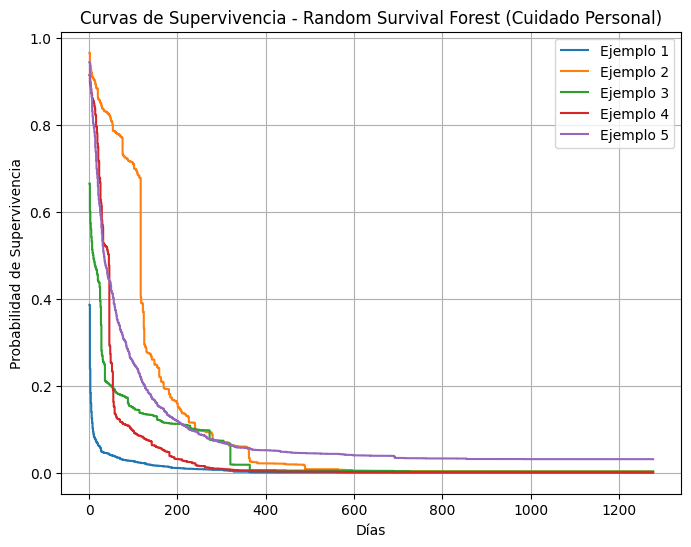

<Figure size 640x480 with 0 Axes>

In [103]:
## RANDOM SURVIVAL FOREST PARA CUIDADO PERSONAL ##

# Transformamos 'df_general_results' y 'df_train_test_results' al formato pd.DataFrame si es Styler
if hasattr(df_general_results, "data"):
    df_general_results = df_general_results.data.copy()
if hasattr(df_train_test_results, "data"):
    df_train_test_results = df_train_test_results.data.copy()
_ = None

# Escalamos los datos con preservación del índice
scaler = StandardScaler()
X_train_cuidado_personal_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_cuidado_personal),
    index=pd.RangeIndex(len(X_train_cuidado_personal)),
    columns=[f"Feature_{i}" for i in range(X_train_cuidado_personal.shape[1])]
)
X_test_cuidado_personal_scaled = pd.DataFrame(
    scaler.transform(X_test_cuidado_personal),
    index=pd.RangeIndex(len(X_test_cuidado_personal)),
    columns=[f"Feature_{i}" for i in range(X_test_cuidado_personal.shape[1])]
)

# Definimos los hiperparámetros del modelo
rsf_params_cuidado_personal = {
    "n_estimators": 750,
    "min_samples_split": 10,
    "min_samples_leaf": 20,
    "max_features": "log2",
    "max_depth": 15,
    "random_state": 42,
    "n_jobs": -1
}

# Entrenamos el modelo directamente con los datos de entrenamiento
best_rsf_model_cuidado_personal = RandomSurvivalForest(**rsf_params_cuidado_personal)
best_rsf_model_cuidado_personal.fit(X_train_cuidado_personal_scaled, y_train_cuidado_personal)

# Evaluamos el modelo con Concordance Index
c_index_test_cuidado_personal = concordance_index_censored(
    y_test_cuidado_personal["Evento"], y_test_cuidado_personal["Duración"], 
    best_rsf_model_cuidado_personal.predict(X_test_cuidado_personal_scaled)
)[0]

c_index_train_cuidado_personal = concordance_index_censored(
    y_train_cuidado_personal["Evento"], y_train_cuidado_personal["Duración"], 
    best_rsf_model_cuidado_personal.predict(X_train_cuidado_personal_scaled)
)[0]

print(f"Hiperparámetros del Modelo RSF para Cuidado Personal: {rsf_params_cuidado_personal}\n")
print(f"Concordance Index (C-index) en Train para Cuidado Personal: {c_index_train_cuidado_personal:.3f}")
print(f"Concordance Index (C-index) en Test para Cuidado Personal: {c_index_test_cuidado_personal:.3f}\n")

# Definimos la grilla de tiempo para las predicciones
fecha_inicio = datetime(2021, 1, 1)
fecha_fin = datetime(2024, 6, 30)
diferencia_dias = (fecha_fin - fecha_inicio).days
time_grid = np.arange(1, diferencia_dias + 1, 1)

# Generamos las curvas de supervivencia en Train
survival_curves_train_raw = best_rsf_model_cuidado_personal.predict_survival_function(X_train_cuidado_personal_scaled)
survival_curves_train = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_train_raw]),
    index=time_grid,
    columns=X_train_cuidado_personal_scaled.index
)

# Evaluamos con SurvivalEVAL en Train
eval_RSF_train = LifelinesEvaluator(
    survival_curves_train, 
    y_train_cuidado_personal["Duración"], y_train_cuidado_personal["Evento"],
    y_train_cuidado_personal["Duración"], y_train_cuidado_personal["Evento"]
)
mae_RSF_uncensored_train_cuidado_personal = eval_RSF_train.mae(method="Uncensored")

# Generamos las curvas de supervivencia en Test
survival_curves_raw = best_rsf_model_cuidado_personal.predict_survival_function(X_test_cuidado_personal_scaled)
survival_curves = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_raw]),  
    index=time_grid,  
    columns=X_test_cuidado_personal_scaled.index
)

# Evaluamos con SurvivalEVAL en Test
eval_RSF = LifelinesEvaluator(
    survival_curves, 
    y_test_cuidado_personal["Duración"], y_test_cuidado_personal["Evento"],
    y_train_cuidado_personal["Duración"], y_train_cuidado_personal["Evento"]
)
mae_RSF_uncensored_test_cuidado_personal = eval_RSF.mae(method="Uncensored")

# Imprimimos valores obtenidos
print(f"MAE RSF (con datos no censurados) en Train para Cuidado Personal: {mae_RSF_uncensored_train_cuidado_personal:.3f}")
print(f"MAE RSF (con datos no censurados) en Test para Cuidado Personal: {mae_RSF_uncensored_test_cuidado_personal:.3f}\n")

# Guardamos el modelo y sus métricas en un diccionario 
model_metadata_rsf_cuidado_personal = {
    "modelo": best_rsf_model_cuidado_personal,
    "c_index_train": c_index_train_cuidado_personal,
    "c_index_test": c_index_test_cuidado_personal,
    "mae_uncensored_train": mae_RSF_uncensored_train_cuidado_personal,
    "mae_uncensored_test": mae_RSF_uncensored_test_cuidado_personal,
    "hiperparametros": rsf_params_cuidado_personal
}

# Guardamos el modelo entrenado en formato diccionario con los resultados de los estadísticos
output_dir = "./CUIDADO PERSONAL"
os.makedirs(output_dir, exist_ok=True)
model_filename = os.path.join(output_dir, "Random_Survival_Forest_Cuidado_Personal.pkl")
joblib.dump(model_metadata_rsf_cuidado_personal, model_filename, compress=3)

# Guardamos los resultados en 'df_general_results'
if not ((df_general_results["Modelo"] == "Random Survival Forest") & (df_general_results["Rubro"] == "Cuidado Personal")).any():
    df_general_results = pd.concat([df_general_results, pd.DataFrame({
        "Rubro": ["Cuidado Personal"],
        "Modelo": ["Random Survival Forest"],
        "C-Index": [c_index_test_cuidado_personal],
        "MAE": [mae_RSF_uncensored_test_cuidado_personal], 
        "Características": [str(rsf_params_cuidado_personal)]
    })], ignore_index=True)

# Guardamos los resultados en 'df_train_test_results' 
if not ((df_train_test_results["Modelo"] == "Random Survival Forest") & (df_train_test_results["Rubro"] == "Cuidado Personal")).any():
    df_train_test_results = pd.concat([df_train_test_results, pd.DataFrame({
        "Rubro": ["Cuidado Personal"],
        "Modelo": ["Random Survival Forest"],
        "Test_C-Index": [c_index_test_cuidado_personal], 
        "Train_C-Index": [c_index_train_cuidado_personal],
        "Test_MAE": [mae_RSF_uncensored_test_cuidado_personal], 
        "Train_MAE": [mae_RSF_uncensored_train_cuidado_personal] 
    })], ignore_index=True)

# Proyección de la curva de supervivencia en ejemplos de test
num_samples = 5
sample_indices = np.random.choice(X_test_cuidado_personal_scaled.shape[0], num_samples, replace=False)
X_test_sample = X_test_cuidado_personal_scaled.iloc[sample_indices]

# Visualización de las curvas de supervivencia
plt.figure(figsize=(8, 6))
for i, surv_func in enumerate(best_rsf_model_cuidado_personal.predict_survival_function(X_test_sample)):
    plt.step(surv_func.x, surv_func.y, where="post", label=f"Ejemplo {i+1}")

plt.xlabel("Días")
plt.ylabel("Probabilidad de Supervivencia")
plt.title("Curvas de Supervivencia - Random Survival Forest (Cuidado Personal)")
plt.legend()
plt.grid()
plt.show()

# Guardamos la imagen de las curvas de supervivencia
image_filename = os.path.join(output_dir, "Random_Survival_Forest_Curva_de_Supervivencia_Cuidado_Personal.png")
plt.savefig(image_filename, dpi=300, bbox_inches="tight")

In [105]:
## ANÁLISIS NUMÉRICO DE OVERFITTING PARA SURVIVAL RANDOM FOREST (CUIDADO PERSONAL) ##

# Evaluamos el modelo en el conjunto completo de entrenamiento y prueba
c_index_train_cuidado_personal = concordance_index_censored(
    y_train_cuidado_personal["Evento"],  
    y_train_cuidado_personal["Duración"], 
    best_rsf_model_cuidado_personal.predict(X_train_cuidado_personal)
)[0]

c_index_test_cuidado_personal = concordance_index_censored(
    y_test_cuidado_personal["Evento"],  
    y_test_cuidado_personal["Duración"], 
    best_rsf_model_cuidado_personal.predict(X_test_cuidado_personal)
)[0]

# Imprimimos resultados
print(f"\nConcordance Index (C-index) para Cuidado Personal en Train: {c_index_train_cuidado_personal:.3f}")
print(f"Concordance Index (C-index) para Cuidado Personal en Test: {c_index_test_cuidado_personal:.3f}")

# Comparación de resultados
if c_index_train_cuidado_personal - c_index_test_cuidado_personal > 0.05:
    print("Posible Overfitting: El modelo tiene un mejor desempeño en entrenamiento que en prueba para Cuidado Personal.")
else:
    print("No hay signos evidentes de Overfitting en Cuidado Personal.")


Concordance Index (C-index) para Cuidado Personal en Train: 0.660
Concordance Index (C-index) para Cuidado Personal en Test: 0.661
No hay signos evidentes de Overfitting en Cuidado Personal.


#### **2.2.5**   **<ins>Limpieza</ins>**

In [71]:
### DEFINICIÓN DEL CONJUNTO PARA LIMPIEZA ###

# Filtramos solo los registros del rubro "Limpieza"
df_limpieza = df_price_spells[df_price_spells["Rubro"] == "Limpieza"].copy()

# Convertimos el DataFrame al formato de supervivencia
y_limpieza = Surv.from_dataframe("Evento", time_variable, df_limpieza)
encoder_limpieza = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Aplicamos el OneHotEncoder a las variables categóricas
X_cat_limpieza = encoder_limpieza.fit_transform(df_limpieza[categorical_columns])

# Extraemos las variables numéricas
X_num_limpieza = df_limpieza[numeric_columns].values

# Concatenamos ambas partes para formar la matriz final de predictores
X_final_limpieza = np.concatenate([X_cat_limpieza, X_num_limpieza], axis=1)

# Dividimos en 70% Train y 30% Test directamente
X_train_limpieza, X_test_limpieza, y_train_limpieza, y_test_limpieza = train_test_split(
    X_final_limpieza, y_limpieza, test_size=0.3, random_state=42
)

# Verificamos los tamaños de cada conjunto
total_registros_limpieza = X_final_limpieza.shape[0]
print(f"Tamaño del conjunto de entrenamiento: {X_train_limpieza.shape[0]} ({(X_train_limpieza.shape[0] / total_registros_limpieza) * 100:.2f}%)")
print(f"Tamaño del conjunto de prueba: {X_test_limpieza.shape[0]} ({(X_test_limpieza.shape[0] / total_registros_limpieza) * 100:.2f}%)")

Tamaño del conjunto de entrenamiento: 7459 (70.00%)
Tamaño del conjunto de prueba: 3197 (30.00%)


##### **2.2.5.1**    **<ins>Cox</ins>** ***(Cox Proportional Hazards Model)***

Mejores hiperparámetros para Limpieza: {'alpha_min_ratio': 0.01, 'l1_ratio': 0.5}

Concordance Index (C-index) para Limpieza en Train: 0.719
Concordance Index (C-index) para Limpieza en Test: 0.717

MAE COX (con datos no censurados) para Limpieza en Train: 52.984
MAE COX (con datos no censurados) para Limpieza en Test: 52.639



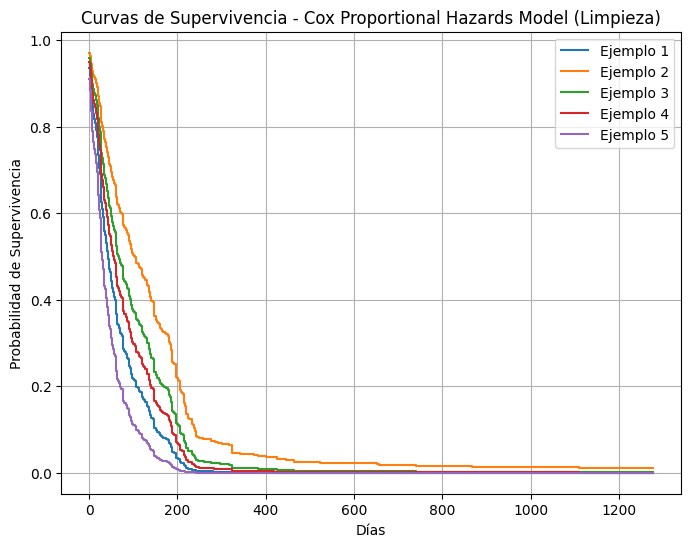

<Figure size 640x480 with 0 Axes>

In [72]:
## COX (Cox Proportional Hazards Model) PARA LIMPIEZA ##

# Transformamos 'df_general_results' y 'df_train_test_results' al formato pd.DataFrame si es Styler
if hasattr(df_general_results, "data"):
    df_general_results = df_general_results.data.copy()
if hasattr(df_train_test_results, "data"):
    df_train_test_results = df_train_test_results.data.copy()
_ = None

# Escalamos los datos con preservación del índice
scaler = StandardScaler()
X_train_limpieza_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_limpieza),
    index=pd.RangeIndex(len(X_train_limpieza)),
    columns=[f"Feature_{i}" for i in range(X_train_limpieza.shape[1])]
)
X_test_limpieza_scaled = pd.DataFrame(
    scaler.transform(X_test_limpieza),
    index=pd.RangeIndex(len(X_test_limpieza)),
    columns=[f"Feature_{i}" for i in range(X_test_limpieza.shape[1])]
)

# Hiperparametrización COX
param_grid = {
    "l1_ratio": [0.1, 0.5, 0.9],  
    "alpha_min_ratio": [0.001, 0.01, 0.1]  
}

cox_grid = GridSearchCV(
    CoxnetSurvivalAnalysis(fit_baseline_model=True),
    param_grid,
    scoring=lambda est, X, y: concordance_index_censored(y["Evento"], y["Duración"], est.predict(X))[0],
    cv=5,
    n_jobs=-1
)

# Entrenamos el modelo con búsqueda de hiperparámetros
cox_grid.fit(X_train_limpieza_scaled, y_train_limpieza)

# Seleccionamos el mejor modelo
best_cox_model_limpieza = cox_grid.best_estimator_

# Evaluamos el mejor modelo
c_index_test_limpieza = concordance_index_censored(
    y_test_limpieza["Evento"], y_test_limpieza["Duración"], 
    best_cox_model_limpieza.predict(X_test_limpieza_scaled)
)[0]

c_index_train_limpieza = concordance_index_censored(
    y_train_limpieza["Evento"], y_train_limpieza["Duración"], 
    best_cox_model_limpieza.predict(X_train_limpieza_scaled)
)[0]

print(f"Mejores hiperparámetros para Limpieza: {cox_grid.best_params_}\n")
print(f"Concordance Index (C-index) para Limpieza en Train: {c_index_train_limpieza:.3f}")
print(f"Concordance Index (C-index) para Limpieza en Test: {c_index_test_limpieza:.3f}\n")

# Definimos la grilla de tiempo para las predicciones
fecha_inicio = datetime(2021, 1, 1)  
fecha_fin = datetime(2024, 6, 30)  
diferencia_dias = (fecha_fin - fecha_inicio).days
time_grid = np.arange(1, diferencia_dias + 1, 1)  

# Generamos las curvas de supervivencia en Train
survival_curves_train_raw = best_cox_model_limpieza.predict_survival_function(X_train_limpieza_scaled)
survival_curves_train = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_train_raw]),
    index=time_grid,
    columns=X_train_limpieza_scaled.index
)

# Evaluamos con SurvivalEVAL en Train
eval_COX_train = LifelinesEvaluator(
    survival_curves_train, 
    y_train_limpieza["Duración"], y_train_limpieza["Evento"],
    y_train_limpieza["Duración"], y_train_limpieza["Evento"]
)
mae_COX_uncensored_train_limpieza = eval_COX_train.mae(method="Uncensored")

# Generamos las curvas de supervivencia en Test
survival_curves_raw = best_cox_model_limpieza.predict_survival_function(X_test_limpieza_scaled)
survival_curves = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_raw]),  
    index=time_grid,  
    columns=X_test_limpieza_scaled.index
)

# Evaluamos con SurvivalEVAL en Test
eval_COX = LifelinesEvaluator(
    survival_curves, 
    y_test_limpieza["Duración"], y_test_limpieza["Evento"],
    y_train_limpieza["Duración"], y_train_limpieza["Evento"]
)
mae_COX_uncensored_test_limpieza = eval_COX.mae(method="Uncensored")

# Imprimimos valores obtenidos
print(f"MAE COX (con datos no censurados) para Limpieza en Train: {mae_COX_uncensored_train_limpieza:.3f}")
print(f"MAE COX (con datos no censurados) para Limpieza en Test: {mae_COX_uncensored_test_limpieza:.3f}\n")

# Guardamos el modelo y sus métricas en un diccionario 
model_metadata_limpieza = {
    "modelo": best_cox_model_limpieza,
    "c_index_train": c_index_train_limpieza,
    "c_index_test": c_index_test_limpieza,
    "mae_uncensored_train": mae_COX_uncensored_train_limpieza,
    "mae_uncensored_test": mae_COX_uncensored_test_limpieza,
    "hiperparametros": cox_grid.best_params_ 
}

# Guardamos el modelo entrenado en formato diccionario con los resultados de los estadísticos
output_dir = "./LIMPIEZA"
os.makedirs(output_dir, exist_ok=True)
model_filename = os.path.join(output_dir, "Cox_Proportional_Hazards_Model_Limpieza.pkl")
joblib.dump(model_metadata_limpieza, model_filename, compress=3)

# Guardamos los resultados en 'df_general_results'
if not ((df_general_results["Modelo"] == "Cox Proportional Hazards Model") & (df_general_results["Rubro"] == "Limpieza")).any():
    df_general_results = pd.concat([df_general_results, pd.DataFrame({
        "Rubro": ["Limpieza"],
        "Modelo": ["Cox Proportional Hazards Model"],
        "C-Index": [c_index_test_limpieza],
        "MAE": [mae_COX_uncensored_test_limpieza], 
        "Características": [str(cox_grid.best_params_)]
    })], ignore_index=True)

# Guardamos los resultados en 'df_train_test_results'
if not ((df_train_test_results["Modelo"] == "Cox Proportional Hazards Model") & (df_train_test_results["Rubro"] == "Limpieza")).any():
    df_train_test_results = pd.concat([df_train_test_results, pd.DataFrame({
        "Rubro": ["Limpieza"],
        "Modelo": ["Cox Proportional Hazards Model"],
        "Test_C-Index": [c_index_test_limpieza], 
        "Train_C-Index": [c_index_train_limpieza],
        "Test_MAE": [mae_COX_uncensored_test_limpieza], 
        "Train_MAE": [mae_COX_uncensored_train_limpieza] 
    })], ignore_index=True)

# Proyección de la curva de supervivencia en ejemplos de test
num_samples = 5
sample_indices = np.random.choice(X_test_limpieza_scaled.shape[0], num_samples, replace=False)
X_test_sample = X_test_limpieza_scaled.iloc[sample_indices]

# Visualización de las curvas de supervivencia
plt.figure(figsize=(8, 6))
for i, surv_func in enumerate(best_cox_model_limpieza.predict_survival_function(X_test_sample)):
    plt.step(surv_func.x, surv_func.y, where="post", label=f"Ejemplo {i+1}")

plt.xlabel("Días")
plt.ylabel("Probabilidad de Supervivencia")
plt.title("Curvas de Supervivencia - Cox Proportional Hazards Model (Limpieza)")
plt.legend()
plt.grid()
plt.show()

# Guardamos la imagen de las curvas de supervivencia
image_filename = os.path.join(output_dir, "Cox_Proportional_Hazards_Model_Curva_de_Supervivencia_Limpieza.png")
plt.savefig(image_filename, dpi=300, bbox_inches="tight")

In [74]:
## ANÁLISIS NUMÉRICO DE OVERFITTING PARA COX (Cox Proportional Hazards Model) (LIMPIEZA) ##

# Evaluamos el modelo en el conjunto completo de entrenamiento y prueba
c_index_train_limpieza = concordance_index_censored(
    y_train_limpieza["Evento"],  
    y_train_limpieza["Duración"], 
    best_cox_model_limpieza.predict(X_train_limpieza_scaled)
)[0]

c_index_test_limpieza = concordance_index_censored(
    y_test_limpieza["Evento"],  
    y_test_limpieza["Duración"], 
    best_cox_model_limpieza.predict(X_test_limpieza_scaled)
)[0]

# Imprimimos resultados
print(f"\nConcordance Index (C-index) para Limpieza en Train: {c_index_train_limpieza:.3f}")
print(f"Concordance Index (C-index) para Limpieza en Test: {c_index_test_limpieza:.3f}")

# Comparación de resultados
if c_index_train_limpieza - c_index_test_limpieza > 0.05:
    print("Posible Overfitting: El modelo tiene un mejor desempeño en entrenamiento que en prueba para Limpieza.")
else:
    print("No hay signos evidentes de Overfitting en Limpieza.")


Concordance Index (C-index) para Limpieza en Train: 0.719
Concordance Index (C-index) para Limpieza en Test: 0.717
No hay signos evidentes de Overfitting en Limpieza.


##### **2.2.5.2**   **<ins>Random Survival Forest</ins>**

Hiperparámetros del Modelo RSF para Limpieza: {'n_estimators': 800, 'min_samples_split': 8, 'min_samples_leaf': 20, 'max_features': 'log2', 'max_depth': None, 'random_state': 42, 'n_jobs': -1}

Concordance Index (C-index) en Train para Limpieza: 0.750
Concordance Index (C-index) en Test para Limpieza: 0.739

MAE RSF (con datos no censurados) en Train para Limpieza: 26.313
MAE RSF (con datos no censurados) en Test para Limpieza: 26.173



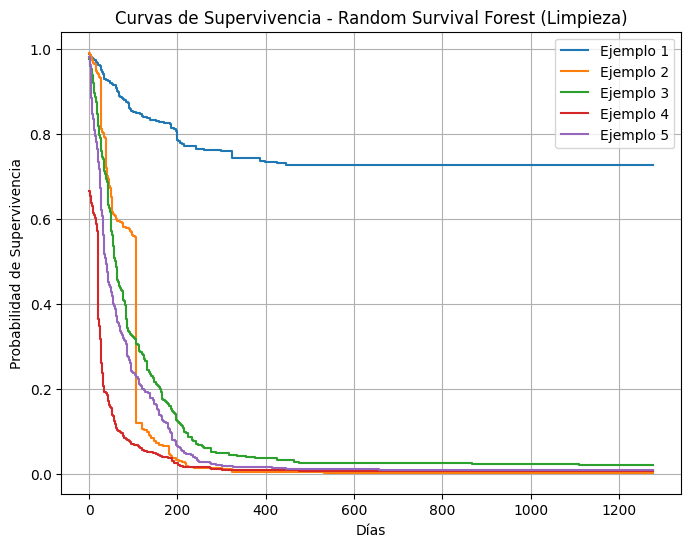

<Figure size 640x480 with 0 Axes>

In [100]:
## RANDOM SURVIVAL FOREST PARA LIMPIEZA ##

# Transformamos 'df_general_results' y 'df_train_test_results' al formato pd.DataFrame si es Styler
if hasattr(df_general_results, "data"):
    df_general_results = df_general_results.data.copy()
if hasattr(df_train_test_results, "data"):
    df_train_test_results = df_train_test_results.data.copy()
_ = None

# Escalamos los datos con preservación del índice
scaler = StandardScaler()
X_train_limpieza_scaled = pd.DataFrame(scaler.fit_transform(X_train_limpieza), index=pd.RangeIndex(len(X_train_limpieza)), columns=[f"Feature_{i}" for i in range(X_train_limpieza.shape[1])])
X_test_limpieza_scaled = pd.DataFrame(scaler.transform(X_test_limpieza), index=pd.RangeIndex(len(X_test_limpieza)), columns=[f"Feature_{i}" for i in range(X_test_limpieza.shape[1])])

# Definimos los hiperparámetros del modelo
rsf_params_limpieza = {
    "n_estimators": 800,
    "min_samples_split": 8,
    "min_samples_leaf": 20,
    "max_features": "log2",
    "max_depth": None,
    "random_state": 42,
    "n_jobs": -1
}

# Entrenamos el modelo directamente con los datos de entrenamiento
best_rsf_model_limpieza = RandomSurvivalForest(**rsf_params_limpieza)
best_rsf_model_limpieza.fit(X_train_limpieza_scaled, y_train_limpieza)

# Evaluamos el modelo con Concordance Index
c_index_test_limpieza = concordance_index_censored(y_test_limpieza["Evento"], y_test_limpieza["Duración"], best_rsf_model_limpieza.predict(X_test_limpieza_scaled))[0]
c_index_train_limpieza = concordance_index_censored(y_train_limpieza["Evento"], y_train_limpieza["Duración"], best_rsf_model_limpieza.predict(X_train_limpieza_scaled))[0]

print(f"Hiperparámetros del Modelo RSF para Limpieza: {rsf_params_limpieza}\n")
print(f"Concordance Index (C-index) en Train para Limpieza: {c_index_train_limpieza:.3f}")
print(f"Concordance Index (C-index) en Test para Limpieza: {c_index_test_limpieza:.3f}\n")

# Definimos la grilla de tiempo para las predicciones
fecha_inicio = datetime(2021, 1, 1)
fecha_fin = datetime(2024, 6, 30)
diferencia_dias = (fecha_fin - fecha_inicio).days
time_grid = np.arange(1, diferencia_dias + 1, 1)

# Generamos las curvas de supervivencia en Train
survival_curves_train_raw = best_rsf_model_limpieza.predict_survival_function(X_train_limpieza_scaled)
survival_curves_train = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_train_raw]),
    index=time_grid,
    columns=X_train_limpieza_scaled.index
)

# Evaluamos con SurvivalEVAL en Train
eval_RSF_train = LifelinesEvaluator(survival_curves_train, y_train_limpieza["Duración"], y_train_limpieza["Evento"],
                                    y_train_limpieza["Duración"], y_train_limpieza["Evento"])
mae_RSF_uncensored_train_limpieza = eval_RSF_train.mae(method="Uncensored")

# Generamos las curvas de supervivencia en Test
survival_curves_raw = best_rsf_model_limpieza.predict_survival_function(X_test_limpieza_scaled)
survival_curves = pd.DataFrame(
    np.column_stack([surv_func(time_grid) for surv_func in survival_curves_raw]),  
    index=time_grid,  
    columns=X_test_limpieza_scaled.index
)

# Evaluamos con SurvivalEVAL en Test
eval_RSF = LifelinesEvaluator(survival_curves, y_test_limpieza["Duración"], y_test_limpieza["Evento"],
                              y_train_limpieza["Duración"], y_train_limpieza["Evento"])
mae_RSF_uncensored_test_limpieza = eval_RSF.mae(method="Uncensored")

# Imprimimos valores obtenidos
print(f"MAE RSF (con datos no censurados) en Train para Limpieza: {mae_RSF_uncensored_train_limpieza:.3f}")
print(f"MAE RSF (con datos no censurados) en Test para Limpieza: {mae_RSF_uncensored_test_limpieza:.3f}\n")

# Guardamos el modelo y sus métricas en un diccionario 
model_metadata_rsf_limpieza = {
    "modelo": best_rsf_model_limpieza,
    "c_index_train": c_index_train_limpieza,
    "c_index_test": c_index_test_limpieza,
    "mae_uncensored_train": mae_RSF_uncensored_train_limpieza,
    "mae_uncensored_test": mae_RSF_uncensored_test_limpieza,
    "hiperparametros": rsf_params_limpieza
}

# Guardamos el modelo entrenado en formato diccionario con los resultados de los estadísticos
output_dir = "./LIMPIEZA"
os.makedirs(output_dir, exist_ok=True)
model_filename = os.path.join(output_dir, "Random_Survival_Forest_Limpieza.pkl")
joblib.dump(model_metadata_rsf_limpieza, model_filename, compress=3)

# Guardamos los resultados en 'df_general_results'
if not ((df_general_results["Modelo"] == "Random Survival Forest") & (df_general_results["Rubro"] == "Limpieza")).any():
    df_general_results = pd.concat([df_general_results, pd.DataFrame({
        "Rubro": ["Limpieza"],
        "Modelo": ["Random Survival Forest"],
        "C-Index": [c_index_test_limpieza],
        "MAE": [mae_RSF_uncensored_test_limpieza], 
        "Características": [str(rsf_params_limpieza)]
    })], ignore_index=True)

# Guardamos los resultados en 'df_train_test_results' 
if not ((df_train_test_results["Modelo"] == "Random Survival Forest") & (df_train_test_results["Rubro"] == "Limpieza")).any():
    df_train_test_results = pd.concat([df_train_test_results, pd.DataFrame({
        "Rubro": ["Limpieza"],
        "Modelo": ["Random Survival Forest"],
        "Test_C-Index": [c_index_test_limpieza], 
        "Train_C-Index": [c_index_train_limpieza],
        "Test_MAE": [mae_RSF_uncensored_test_limpieza], 
        "Train_MAE": [mae_RSF_uncensored_train_limpieza] 
    })], ignore_index=True)

# Proyección de la curva de supervivencia en ejemplos de test
num_samples = 5
sample_indices = np.random.choice(X_test_limpieza_scaled.shape[0], num_samples, replace=False)
X_test_sample = X_test_limpieza_scaled.iloc[sample_indices]

# Visualización de las curvas de supervivencia
plt.figure(figsize=(8, 6))
for i, surv_func in enumerate(best_rsf_model_limpieza.predict_survival_function(X_test_sample)):
    plt.step(surv_func.x, surv_func.y, where="post", label=f"Ejemplo {i+1}")

plt.xlabel("Días")
plt.ylabel("Probabilidad de Supervivencia")
plt.title("Curvas de Supervivencia - Random Survival Forest (Limpieza)")
plt.legend()
plt.grid()
plt.show()

# Guardamos la imagen de las curvas de supervivencia
image_filename = os.path.join(output_dir, "Random_Survival_Forest_Curva_de_Supervivencia_Limpieza.png")
plt.savefig(image_filename, dpi=300, bbox_inches="tight")

In [102]:
## ANÁLISIS NUMÉRICO DE OVERFITTING PARA SURVIVAL RANDOM FOREST (LIMPIEZA) ##

# Evaluamos el modelo en el conjunto completo de entrenamiento y prueba
c_index_train_limpieza = concordance_index_censored(
    y_train_limpieza["Evento"],  
    y_train_limpieza["Duración"], 
    best_rsf_model_limpieza.predict(X_train_limpieza)
)[0]

c_index_test_limpieza = concordance_index_censored(
    y_test_limpieza["Evento"],  
    y_test_limpieza["Duración"], 
    best_rsf_model_limpieza.predict(X_test_limpieza)
)[0]

# Imprimimos resultados
print(f"\nConcordance Index (C-index) para Limpieza en Train: {c_index_train_limpieza:.3f}")
print(f"Concordance Index (C-index) para Limpieza en Test: {c_index_test_limpieza:.3f}")

# Comparación de resultados
if c_index_train_limpieza - c_index_test_limpieza > 0.05:
    print("Posible Overfitting: El modelo tiene un mejor desempeño en entrenamiento que en prueba para Limpieza.")
else:
    print("No hay signos evidentes de Overfitting en Limipieza.")


Concordance Index (C-index) para Limpieza en Train: 0.594
Concordance Index (C-index) para Limpieza en Test: 0.590
No hay signos evidentes de Overfitting en Limipieza.


#### **2.2.6**   **<ins>Resultados Finales</ins>**

In [58]:
## RESULTADOS FINALES ##

# Escala de C-Index
CIndex_escala = """Escala de C-Index:  Muy Débil: 0 - 0.50   |  Débil: 0.50 - 0.60 |  Aceptable: 0.60 - 0.65 | Bueno: 0.65 - 0.70 |  Muy Bueno: 0.70 - 0.75 |  Excelente: 0.75 - 1.00\n\n"""
print(CIndex_escala)

# Nos aseguramos de que el DataFrame no sea un Styler
try:
    df_general_results = df_general_results.data if hasattr(df_general_results, "data") else df_general_results
except Exception as e:
    print("Error al convertir df_general_results:", e)

# Categorización del C-Index
def categorizar_cindex(valor):
    if valor < 0.50:
        return "Muy Débil"
    elif 0.50 <= valor < 0.60:
        return "Débil"
    elif 0.60 <= valor < 0.65:
        return "Aceptable"
    elif 0.65 <= valor < 0.70:
        return "Bueno"
    elif 0.70 <= valor < 0.75:
        return "Muy Bueno"
    else:
        return "Excelente"

# Convertimos C-Index y MAE a numérico, redondeamos y aplicamos la categorización
df_general_results["C-Index"] = pd.to_numeric(df_general_results["C-Index"], errors='coerce').round(2)
df_general_results["Modelado"] = df_general_results["C-Index"].apply(categorizar_cindex)
df_general_results["MAE"] = pd.to_numeric(df_general_results["MAE"], errors='coerce').round(2)

# Reordenamos las columnas para que "Modelado" esté después de "C-Index"
df_general_results = df_general_results[["Rubro", "Modelo", "C-Index", "Modelado", "MAE", "Características"]]

# Ordenamos de mayor a menor por C-Index
df_general_results = df_general_results.sort_values(by="C-Index", ascending=False)

# Función para aplicar colores según el Modelado de C-Index
def color_cindex(val):
    colores = {
        "Muy Débil": "#8B0000",  # Rojo oscuro
        "Débil": "#CD5C5C",      # Rojo claro
        "Aceptable": "#F4A460",  # Naranja
        "Bueno": "#FFD700",      # Amarillo
        "Muy Bueno": "#9ACD32",  # Verde claro
        "Excelente": "#006400"   # Verde oscuro
    }
    return f"background-color: {colores.get(val, 'white')}; color: white; font-weight: bold;"

# Función para aplicar la escala 'Goldens' en MAE (mejor y peor por rubro)
def highlight_best_worst(data):
    first_place = f'background-color: {Goldens[2]}'  # Mejor modelo (dorado oscuro)
    worst_place = f'background-color: {Goldens[0]}'  # Peor modelo (dorado claro)

    styles = pd.DataFrame('', index=data.index, columns=data.columns)

    if "MAE" in data.columns:
        for rubro in data["Rubro"].unique():
            subset = data[data["Rubro"] == rubro]
            if len(subset) > 0:
                best_index = subset["MAE"].idxmin()
                worst_index = subset["MAE"].idxmax()

                styles.loc[best_index, "MAE"] = first_place
                styles.loc[worst_index, "MAE"] = worst_place

    return styles

# Aplicamos los estilos de colores y formato
df_general_results = df_general_results.style.apply(highlight_best_worst, axis=None).map(color_cindex, subset=["Modelado"]).format({
    "C-Index": "{:.2f}",
    "MAE": "{:.2f}"
})

# Ruta del archivo Excel donde guardaremos los resultados
file_path = "MODELO GENERAL/Resumen_Resultados.xlsx"

# Guardamos primero el DataFrame sin estilos en Excel
df_general_results.data.to_excel(file_path, index=False, sheet_name="Resumen")

# Cargamos el archivo para aplicar estilos
wb = load_workbook(file_path)
ws = wb.active

# Definimos los colores desde la paleta Goldens
first_place = PatternFill(start_color=Goldens[2].replace("#", ""), fill_type="solid")  # Dorado oscuro (mejor MAE)
worst_place = PatternFill(start_color=Goldens[0].replace("#", ""), fill_type="solid")  # Dorado claro (peor MAE)

# Colores para Modelado (C-Index)
color_cindex = {
    "Muy Débil": PatternFill(start_color="8B0000", fill_type="solid"),  # Rojo oscuro
    "Débil": PatternFill(start_color="CD5C5C", fill_type="solid"),      # Rojo claro
    "Aceptable": PatternFill(start_color="F4A460", fill_type="solid"),  # Naranja
    "Bueno": PatternFill(start_color="FFD700", fill_type="solid"),      # Amarillo
    "Muy Bueno": PatternFill(start_color="9ACD32", fill_type="solid"),  # Verde claro
    "Excelente": PatternFill(start_color="006400", fill_type="solid")   # Verde oscuro
}

# Aplicamos los colores"
col_idx_modelado = df_general_results.data.columns.get_loc("Modelado") + 1
for row_idx, modelado_val in enumerate(df_general_results.data["Modelado"], start=2):  
    if modelado_val in color_cindex:
        ws.cell(row=row_idx, column=col_idx_modelado).fill = color_cindex[modelado_val]

# Aplicamos los colores de mejor y peor MAE en cada Rubro
col_idx_mae = df_general_results.data.columns.get_loc("MAE") + 1
for rubro in df_general_results.data["Rubro"].unique():
    subset = df_general_results.data[df_general_results.data["Rubro"] == rubro]
    if len(subset) > 0:
        best_index = subset["MAE"].idxmin()
        worst_index = subset["MAE"].idxmax()

        best_row = df_general_results.data.index.get_loc(best_index) + 2  # Ajuste para Excel
        worst_row = df_general_results.data.index.get_loc(worst_index) + 2

        ws.cell(row=best_row, column=col_idx_mae).fill = first_place
        ws.cell(row=worst_row, column=col_idx_mae).fill = worst_place

# Guardamos el archivo Excel con los estilos aplicados
wb.save(file_path)

df_general_results

Escala de C-Index:  Muy Débil: 0 - 0.50   |  Débil: 0.50 - 0.60 |  Aceptable: 0.60 - 0.65 | Bueno: 0.65 - 0.70 |  Muy Bueno: 0.70 - 0.75 |  Excelente: 0.75 - 1.00




,Rubro,Modelo,C-Index,Modelado,MAE,Características
9,Cuidado Personal,Random Survival Forest,0.78,Excelente,26.34,nan
11,Limpieza,Random Survival Forest,0.74,Muy Bueno,26.17,nan
1,Modelo General,Random Survival Forest,0.73,Muy Bueno,33.10,nan
3,Alimentos,Random Survival Forest,0.73,Muy Bueno,26.73,nan
5,Bebidas con Alcohol,Random Survival Forest,0.73,Muy Bueno,23.11,nan
7,Bebidas sin Alcohol,Random Survival Forest,0.73,Muy Bueno,32.69,nan
10,Limpieza,Cox Proportional Hazards Model,0.72,Muy Bueno,52.64,nan
0,Modelo General,Cox Proportional Hazards Model,0.71,Muy Bueno,40.60,nan
4,Bebidas con Alcohol,Cox Proportional Hazards Model,0.70,Muy Bueno,36.44,nan
6,Bebidas sin Alcohol,Cox Proportional Hazards Model,0.67,Bueno,62.16,nan


In [59]:
## DIFERENCIA DE RESULTADOS ENTRE TRAIN Y TEST ##

# Deshacemos el formato .Styler de 'df_train_test_results' si es necesario
if isinstance(df_train_test_results, pd.io.formats.style.Styler):
    df_train_test_results = df_train_test_results.data

# Redondeamos C-Index y MAE a 4 decimales
metricas_redondeo = ["Test_C-Index", "Train_C-Index", "Test_MAE", "Train_MAE"]
df_train_test_results[metricas_redondeo] = df_train_test_results[metricas_redondeo].round(4)

# Columnas de diferencias a calcular
diff_columns = ["Diff_Test_vs_Train_C-Index_%", "Diff_Test_vs_Train_MAE_%"]

# Calculamos diferencias en porcentaje (%)
df_train_test_results["Diff_Test_vs_Train_C-Index_%"] = np.where(
    df_train_test_results["Train_C-Index"] != 0,
    np.round(((df_train_test_results["Test_C-Index"] / df_train_test_results["Train_C-Index"]) - 1) * 100, 2),
    0
)

df_train_test_results["Diff_Test_vs_Train_MAE_%"] = np.where(
    df_train_test_results["Train_MAE"] != 0,
    np.round(((df_train_test_results["Test_MAE"] / df_train_test_results["Train_MAE"]) - 1) * 100, 2),
    0
)

# Convertimos las diferencias a string con "%"
for col in diff_columns:
    df_train_test_results[col] = df_train_test_results[col].astype(str) + " %"

# Reordenamos las columnas para eliminar las extras y mantener solo las necesarias
column_order = [
    "Rubro", "Modelo",  # Información principal
    "Diff_Test_vs_Train_C-Index_%", "Diff_Test_vs_Train_MAE_%",  # Diferencias en porcentaje
    "Test_C-Index", "Train_C-Index", "Test_MAE", "Train_MAE"  # Métricas clave
]

df_train_test_results = df_train_test_results[column_order]

# Aplicamos la paleta Sky Blues para las diferencias
all_diffs = df_train_test_results[diff_columns].replace(" %", "", regex=True).astype(float)
min_val, max_val = all_diffs.min().min(), all_diffs.max().max()

# Función para resaltar diferencias con la misma escala de colores en todas las columnas
def highlight_differences(val):
    try:
        val_numeric = float(val.replace(" %", ""))
        cmap = LinearSegmentedColormap.from_list("sky_blues_cmap", Sky_Blues)  
        norm = plt.Normalize(vmin=min_val, vmax=max_val)
        rgba = plt.cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(val_numeric)

        r, g, b, a = int(rgba[0] * 255), int(rgba[1] * 255), int(rgba[2] * 255), rgba[3]
        return f'background-color: rgba({r}, {g}, {b}, {a})'
    except:
        return ''

# Aplicamos estilos con la misma escala de colores en todas las diferencias
df_train_test_results = df_train_test_results.style.applymap(highlight_differences, subset=diff_columns)

# Aplicamos formato a todas las columnas numéricas con 4 decimales
df_train_test_results = df_train_test_results.format(
    {col: "{:.4f}" for col in df_train_test_results.data.select_dtypes(include=["number"]).columns}
)

# Guardamos la tabla en Excel
file_path = "MODELO GENERAL/Comparative Results (Train vs Test).xlsx"

# Guardamos en Excel sin formato de colores
df_train_test_results.data.to_excel(file_path, index=False, sheet_name="Diferencias")

# Aplicamos los estilos de colores en Excel
wb = load_workbook(file_path)
ws = wb.active

# Aplicamos los colores de la paleta Sky_Blues a las columnas de diferencia
for col in diff_columns:
    if col in df_train_test_results.data.columns:
        col_idx = df_train_test_results.data.columns.get_loc(col) + 1  # Índice en Excel (1-based)
        for row_idx, value in enumerate(df_train_test_results.data[col].replace(" %", "", regex=True).astype(float)):
            norm_val = (value - min_val) / (max_val - min_val) if max_val != min_val else 0.5
            color_idx = int(norm_val * (len(Sky_Blues) - 1))
            fill_color = PatternFill(start_color=Sky_Blues[color_idx].replace("#", ""), fill_type="solid")
            ws.cell(row=row_idx + 2, column=col_idx).fill = fill_color

# Guardamos el archivo con los estilos aplicados
wb.save(file_path)

df_train_test_results

,Rubro,Modelo,Diff_Test_vs_Train_C-Index_%,Diff_Test_vs_Train_MAE_%,Test_C-Index,Train_C-Index,Test_MAE,Train_MAE
0,Modelo General,Cox Proportional Hazards Model,-0.32 %,0.32 %,0.7074,0.7097,40.6030,40.4715
1,Modelo General,Random Survival Forest,-0.3 %,1.19 %,0.7287,0.7309,33.1037,32.7131
2,Alimentos,Cox Proportional Hazards Model,0.21 %,1.16 %,0.6533,0.6519,33.3515,32.9683
3,Alimentos,Random Survival Forest,0.08 %,1.3 %,0.7314,0.7308,26.7334,26.3909
4,Bebidas con Alcohol,Cox Proportional Hazards Model,0.43 %,-14.49 %,0.6963,0.6933,36.4382,42.6126
5,Bebidas con Alcohol,Random Survival Forest,1.51 %,11.0 %,0.7319,0.7210,23.1051,20.8152
6,Bebidas sin Alcohol,Cox Proportional Hazards Model,-0.55 %,2.09 %,0.6721,0.6758,62.1646,60.8890
7,Bebidas sin Alcohol,Random Survival Forest,-0.05 %,5.28 %,0.7347,0.7351,32.6932,31.0542
8,Cuidado Personal,Cox Proportional Hazards Model,0.15 %,-0.19 %,0.6638,0.6628,50.7918,50.8906
9,Cuidado Personal,Random Survival Forest,-0.15 %,0.19 %,0.7823,0.7835,26.3431,26.2930
